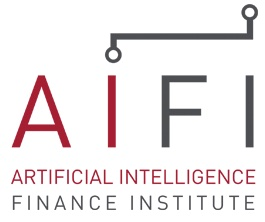


# Bootcamp - Python and Coding - Deep Learning

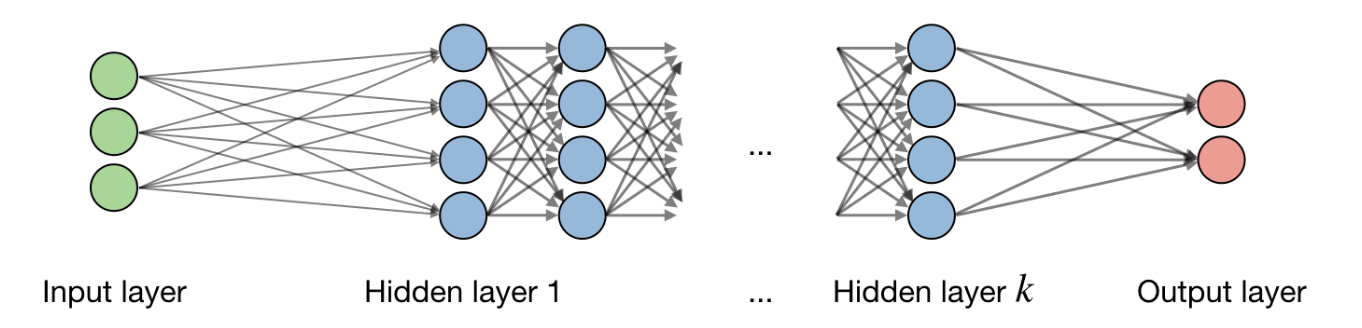

By noting $i$ the $i^{th} $ layer of the network and $j$ the $j^{th}$ hidden unit of the layer, we have:

$$
z_{j}^{[i]}=w_{j}^{[i]^{T}} x+b_{j}^{[i]}
$$

where we note $w$, $b$, $z$ the weight, bias and output respectively.

### Learning Rate
The learning rate, often noted $\alpha$ or sometimes $\eta$, indicates at which pace the weights get updated. This can be fixed or adaptively changed. The current most popular method is called Adam, which is a method that adapts the learning rate.

Batch normalization is a step of hyperparameter $\gamma$, $\beta$, that normalizes the batch $\{x_i\}$. By noting $\mu_B, \sigma_B^2$ the mean and variance of that we want to correct to the batch, it is done as follows:

$$
x_{i} \longleftarrow \gamma \frac{x_{i}-\mu_{B}}{\sqrt{\sigma_{B}^{2}+\epsilon}}+\beta
$$

It is usually done after a fully connected/convolutional layer and before a non-linearity layer and aims at allowing higher learning rates and reducing the strong dependence on initialization.

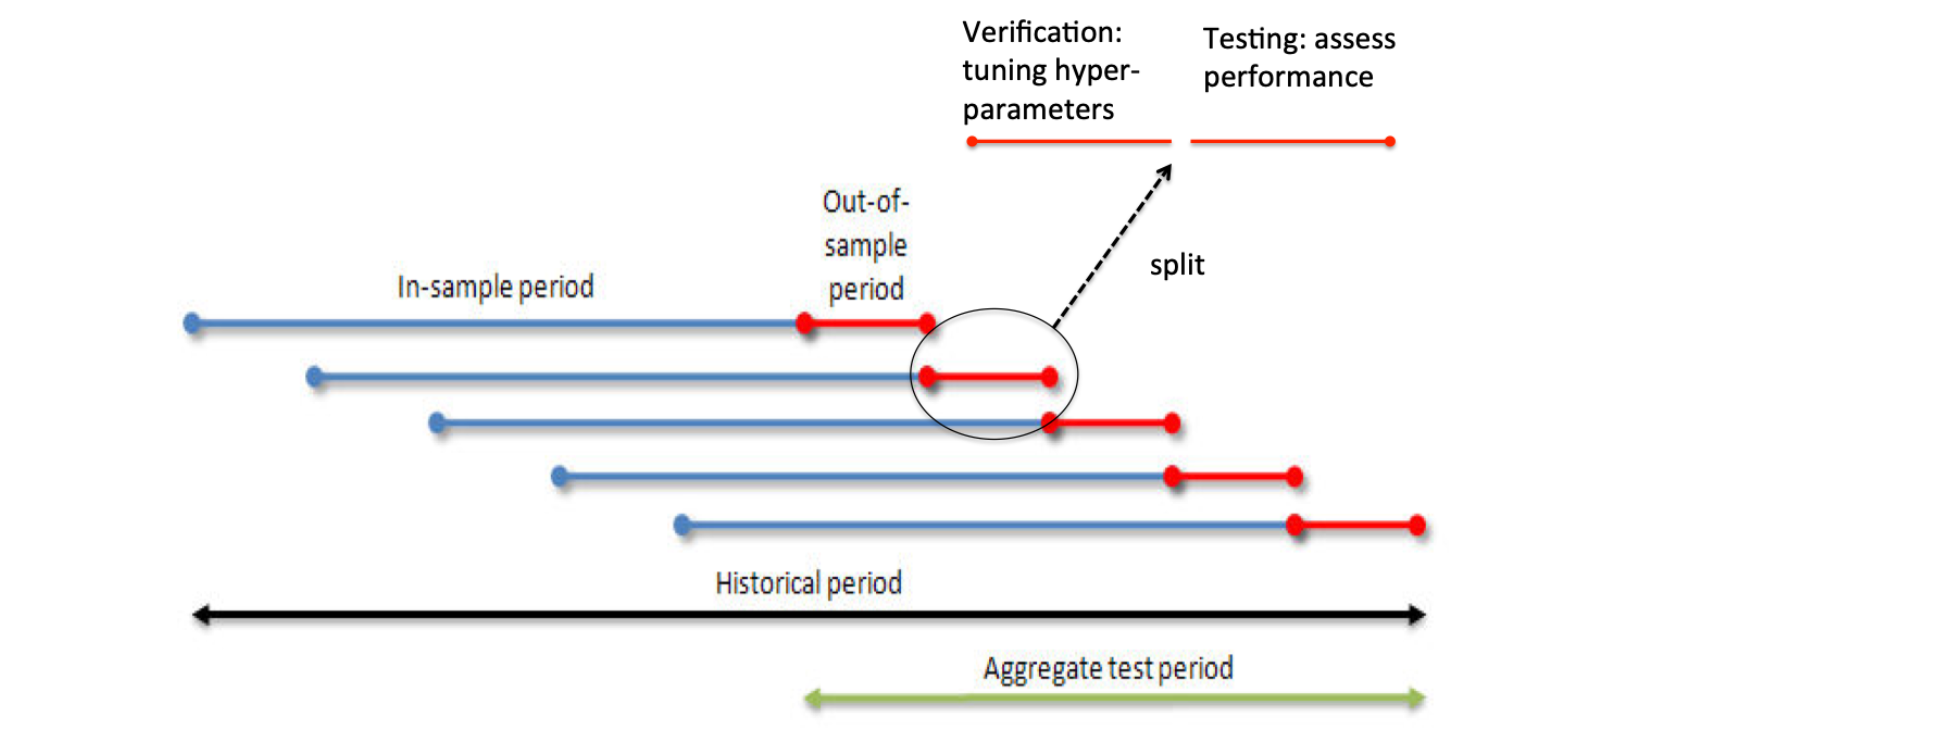

Times series cross validation, also referred to as walk forward optimization, is used instead of standard cross validation to preserve the ordering of the data. This experimental design avoids look-ahead bias in the fitted model which occurs when one or more observations in the training set are from the future.

---

# Imports

In [1]:
# standard imports
import numpy as np
import pandas as pd
from pylab import plt, mpl
import os

# sklearn imports
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score

# tensorflow and keras imports
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping



# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# surpress scientific notation
pd.options.display.float_format = '{:.8f}'.format

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '6'

In [2]:
# imports for plotting
from matplotlib import rcParams
import seaborn as sns
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
matplotlib_axes_logger.setLevel('ERROR')


# global custom setting for the running commands matplotlib or sns
plt.rcParams['axes.titlepad'] = 30
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['scatter.marker'] = 'o'

sns.set_style('whitegrid', {'axes.facecolor': '.995'})

# use the custom style sheet 
plt.style.use('../../custom_plot_style.mplstyle')  

## Data

In [3]:
PATH = '../../data/'
DATA = 'tr_eikon_eod_data.csv'

In [4]:
raw = pd.read_csv(PATH + DATA, index_col=0, parse_dates=True)['EUR=']

In [5]:
raw.head()

Date
2010-01-01   1.43230000
2010-01-04   1.44110000
2010-01-05   1.43680000
2010-01-06   1.44120000
2010-01-07   1.43180000
Name: EUR=, dtype: float64

In [6]:
raw.tail()

Date
2018-06-25   1.17020000
2018-06-26   1.16450000
2018-06-27   1.15520000
2018-06-28   1.15670000
2018-06-29   1.16830000
Name: EUR=, dtype: float64

In [7]:
l = raw.resample('1M').last()

In [8]:
l.tail()

Date
2018-02-28   1.21930000
2018-03-31   1.23210000
2018-04-30   1.20770000
2018-05-31   1.16900000
2018-06-30   1.16830000
Freq: M, Name: EUR=, dtype: float64

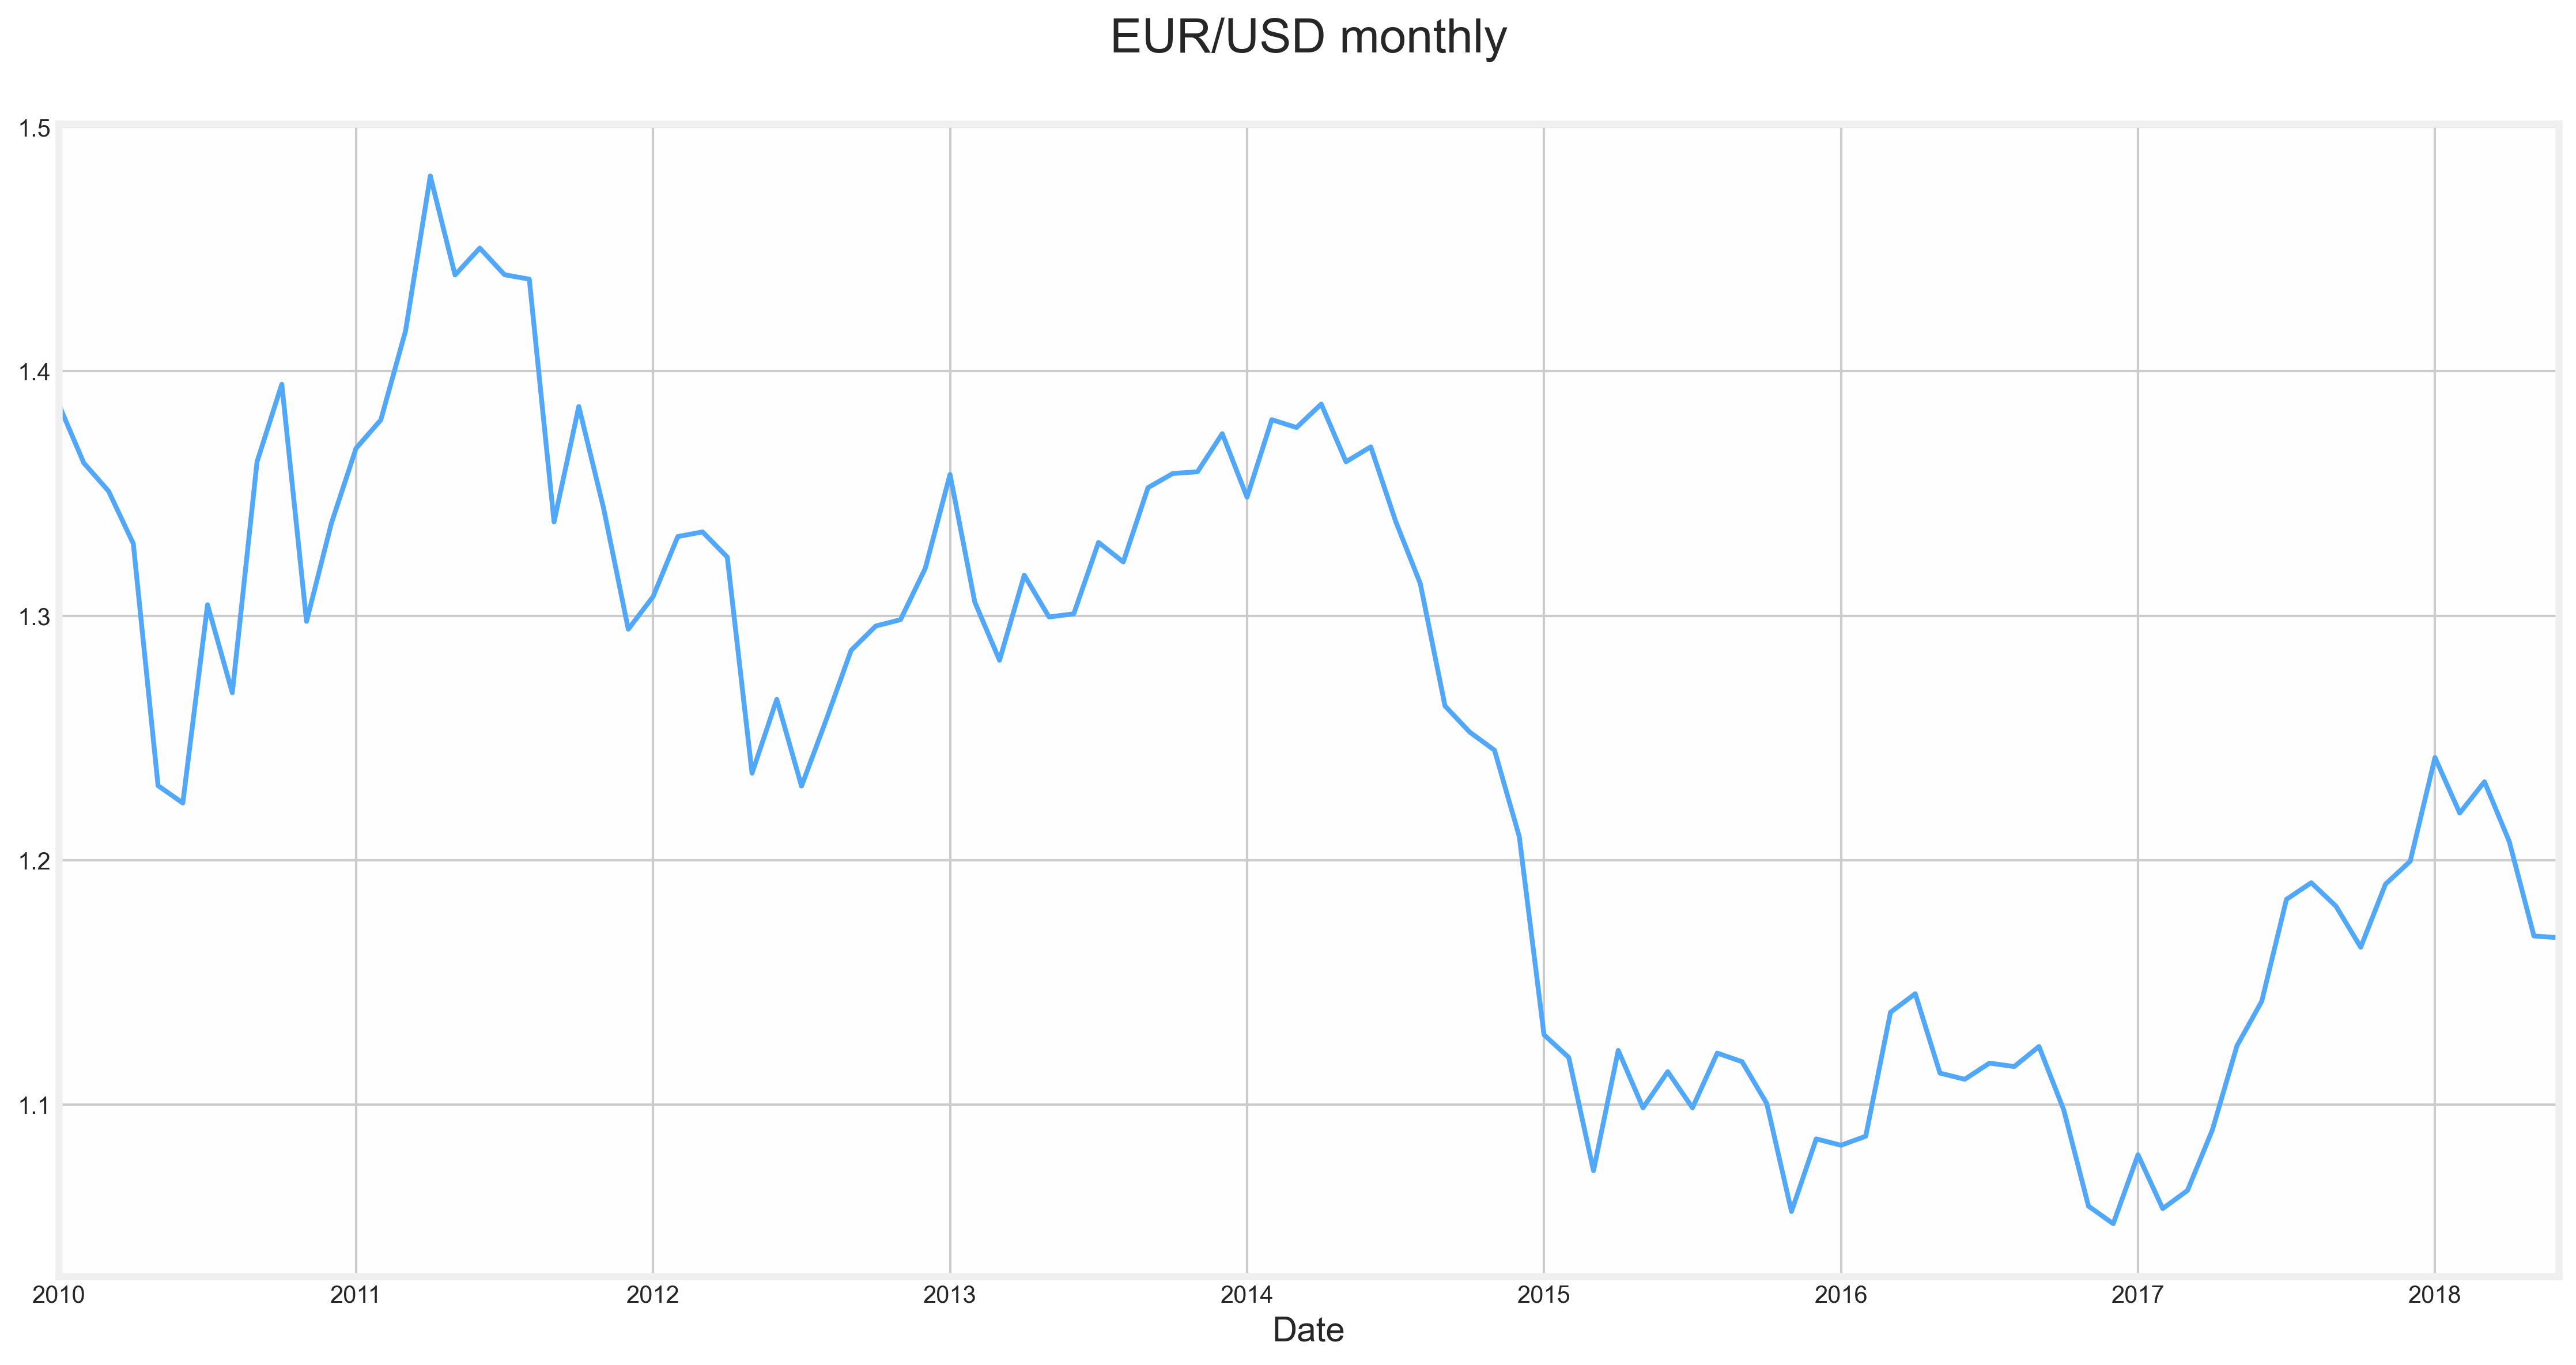

In [9]:
l.plot(figsize=(15, 8), title='EUR/USD monthly');

In [10]:
l = l.values
l -= l.mean()

In [11]:
f = np.linspace(-2, 2, len(l))

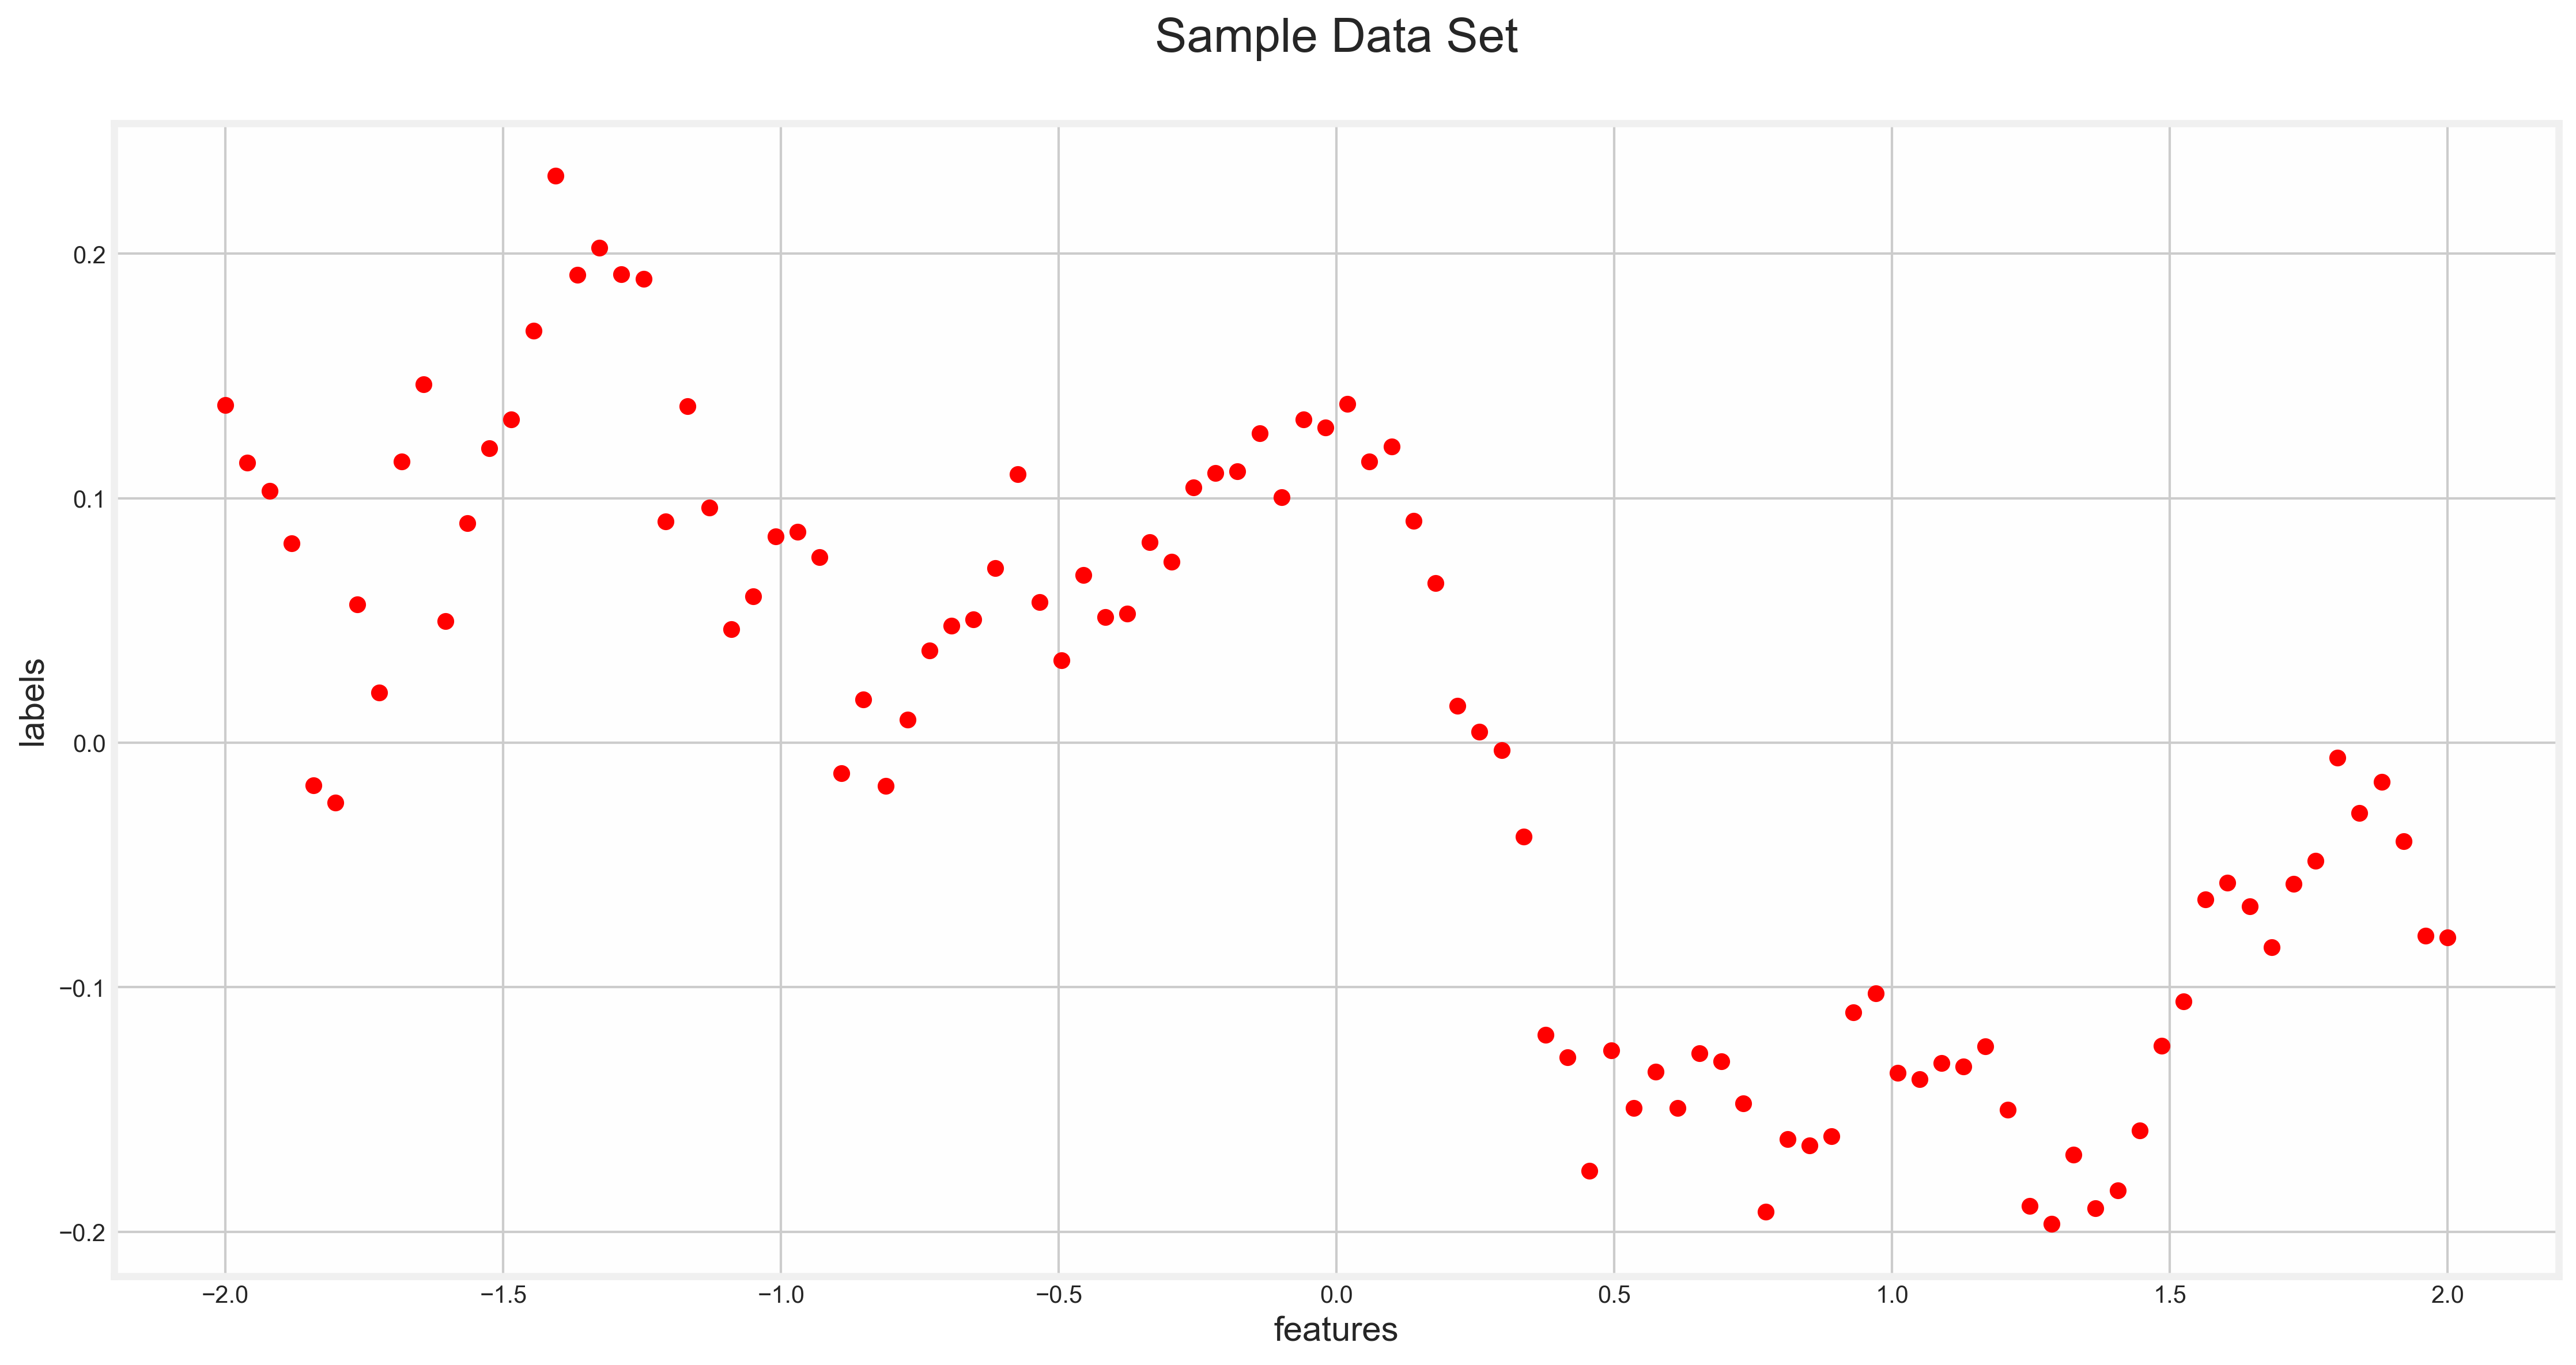

In [12]:
plt.figure(figsize=(15, 8))
plt.plot(f, l, 'ro')
plt.title('Sample Data Set')
plt.xlabel('features')
plt.ylabel('labels');

## Success

In [13]:
def MSE(l, p):
    return np.mean((l - p) ** 2)

In [14]:
reg = np.polyfit(f, l, deg=5)
reg

array([-0.00369682,  0.01610869,  0.05304799, -0.05652948, -0.17593964,
        0.02326254])

In [15]:
p = np.polyval(reg, f)

In [16]:
MSE(l, p)

0.0035301184629877576

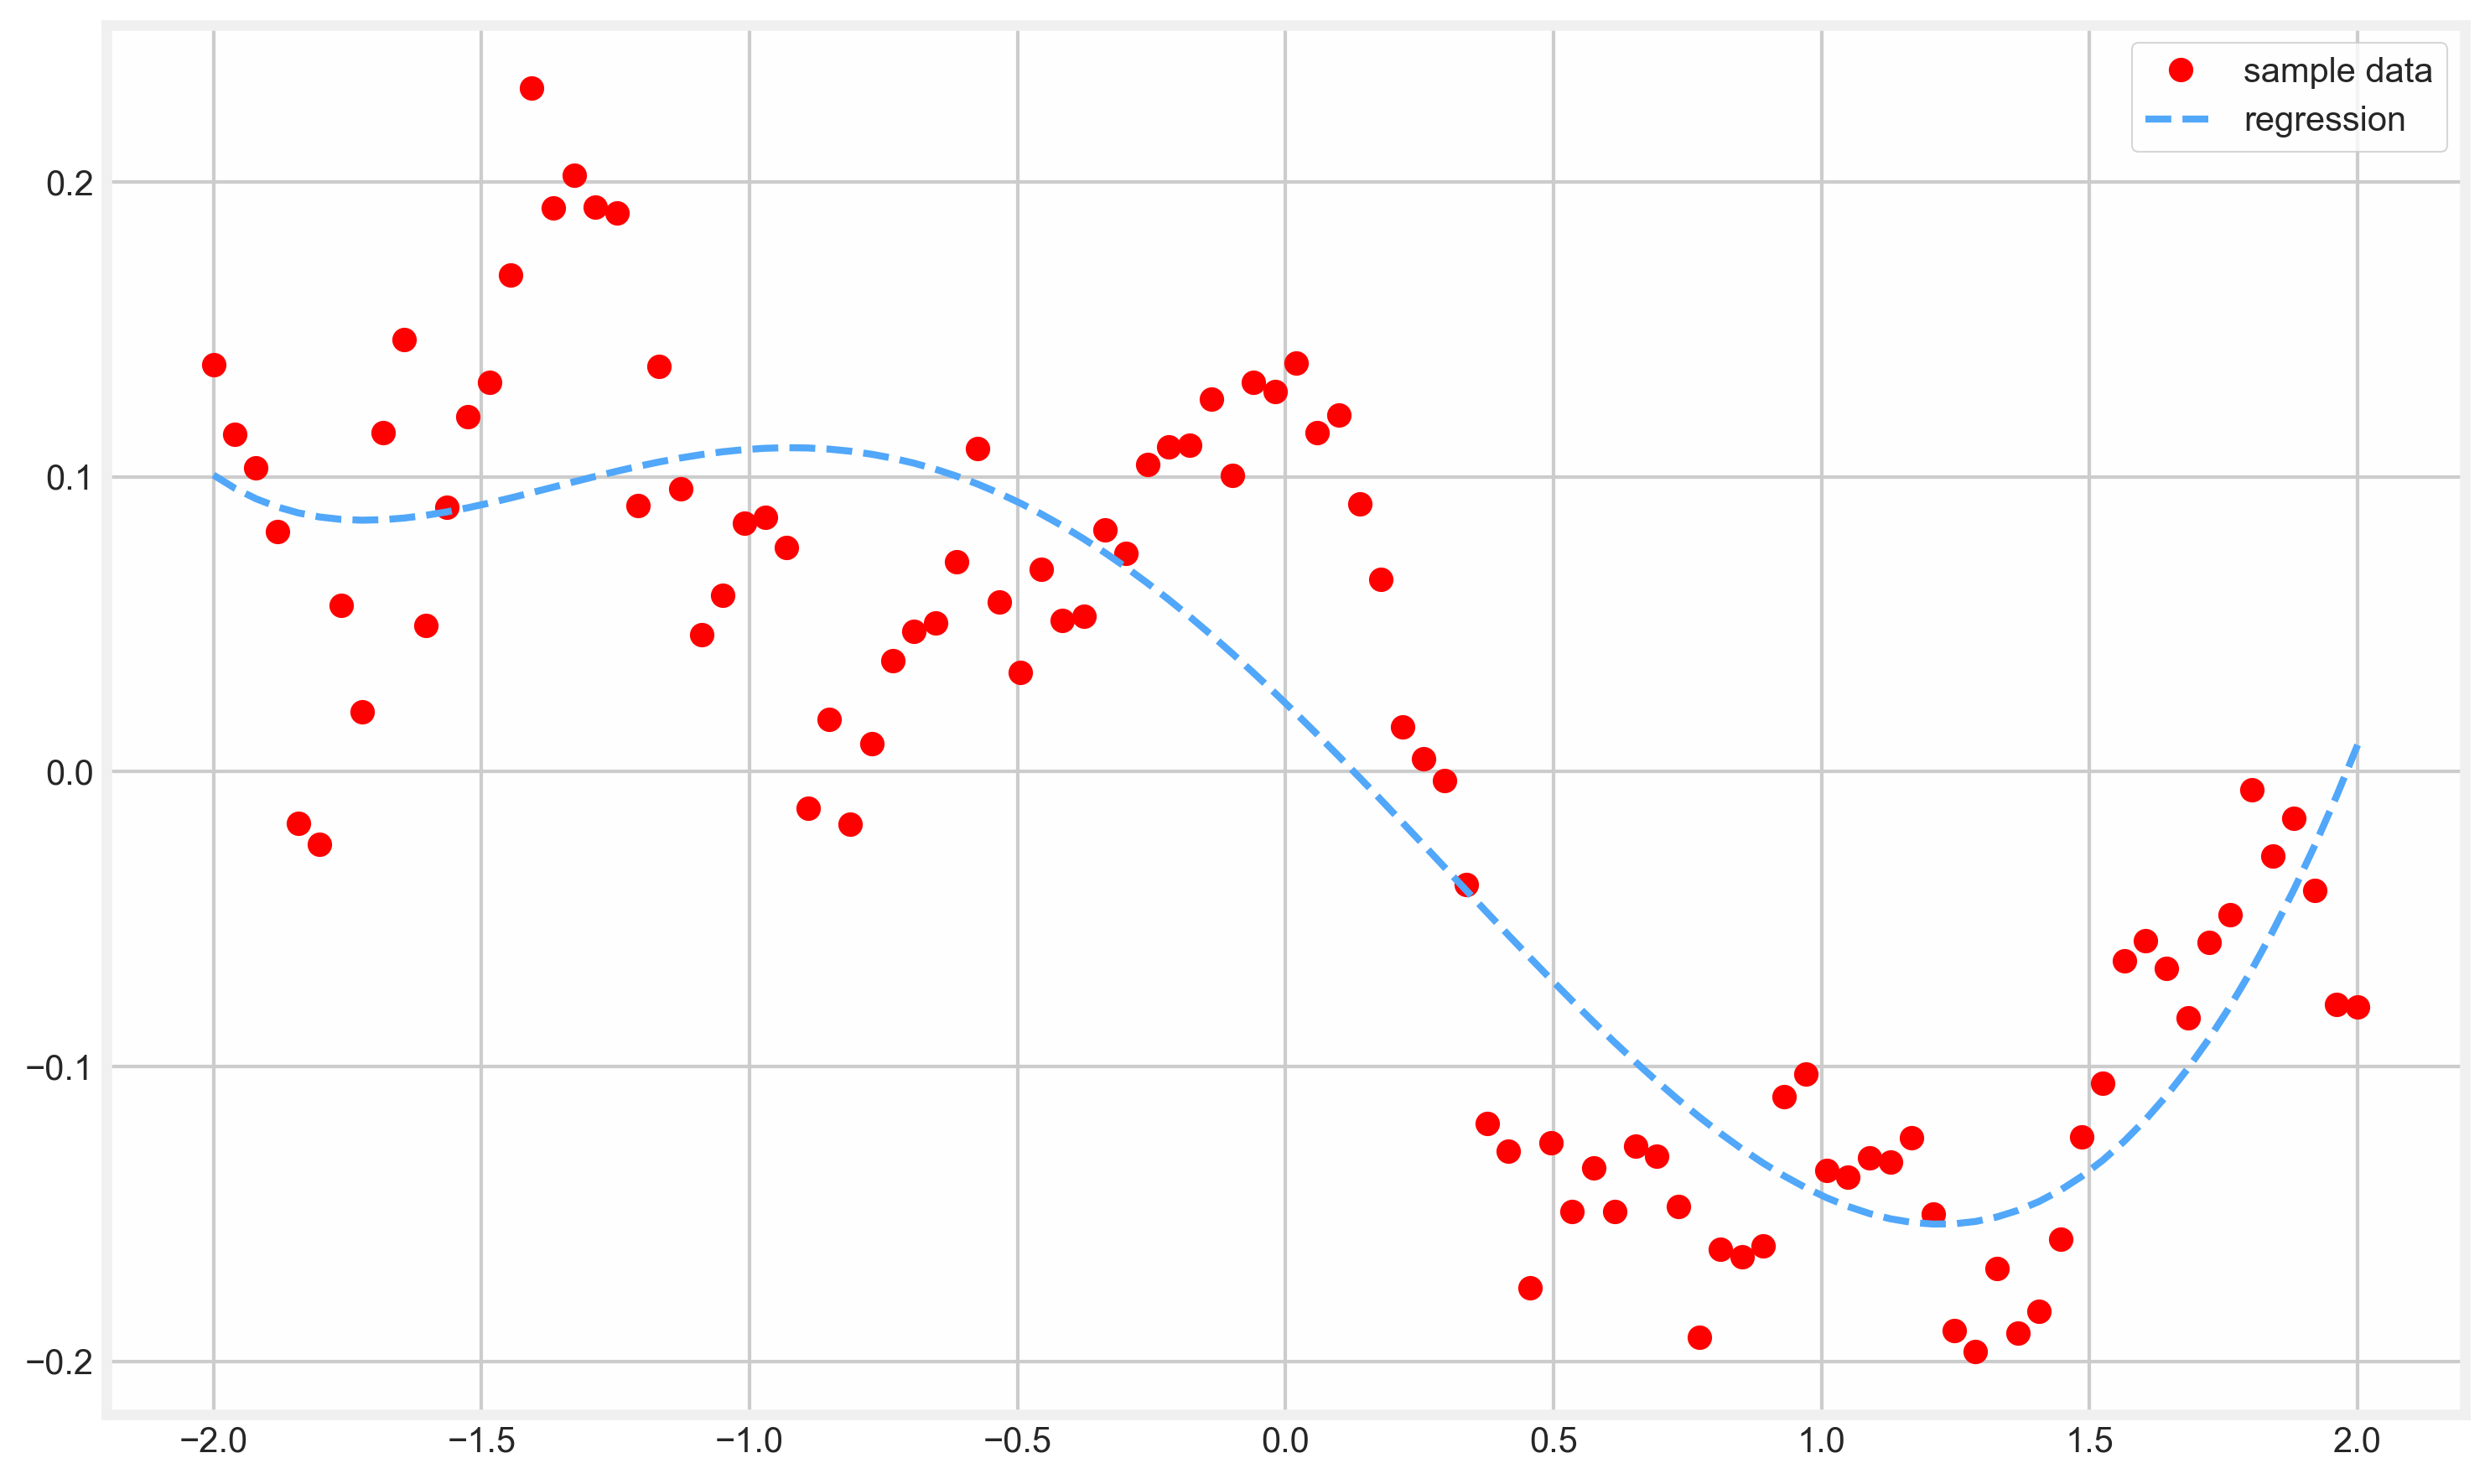

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(f, l, 'ro', label='sample data')
plt.plot(f, p, '--', label='regression')
plt.legend();

In [18]:
%%time
for i in range(10, len(f) + 1, 20):
    reg = np.polyfit(f[:i], l[:i], deg=3)
    p = np.polyval(reg, f)
    mse = MSE(l, p)
    print(f'{i:3d} | MSE={mse}')

 10 | MSE=86850.77984562812
 30 | MSE=221.23370306758028
 50 | MSE=3.054123165004134
 70 | MSE=0.15663456476851106
 90 | MSE=0.006003797637682857
CPU times: user 1.86 ms, sys: 453 µs, total: 2.31 ms
Wall time: 1.95 ms


In [19]:
model = Sequential()  
model.add(Dense(256, activation='relu', input_dim=1))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='rmsprop')

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               512       
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________


In [21]:
%time hist = model.fit(f, l, epochs=1500, verbose=False)

CPU times: user 5.1 s, sys: 606 ms, total: 5.71 s
Wall time: 3.88 s


In [22]:
p = model.predict(f).flatten()

In [23]:
MSE(l, p)

0.001411310721357984

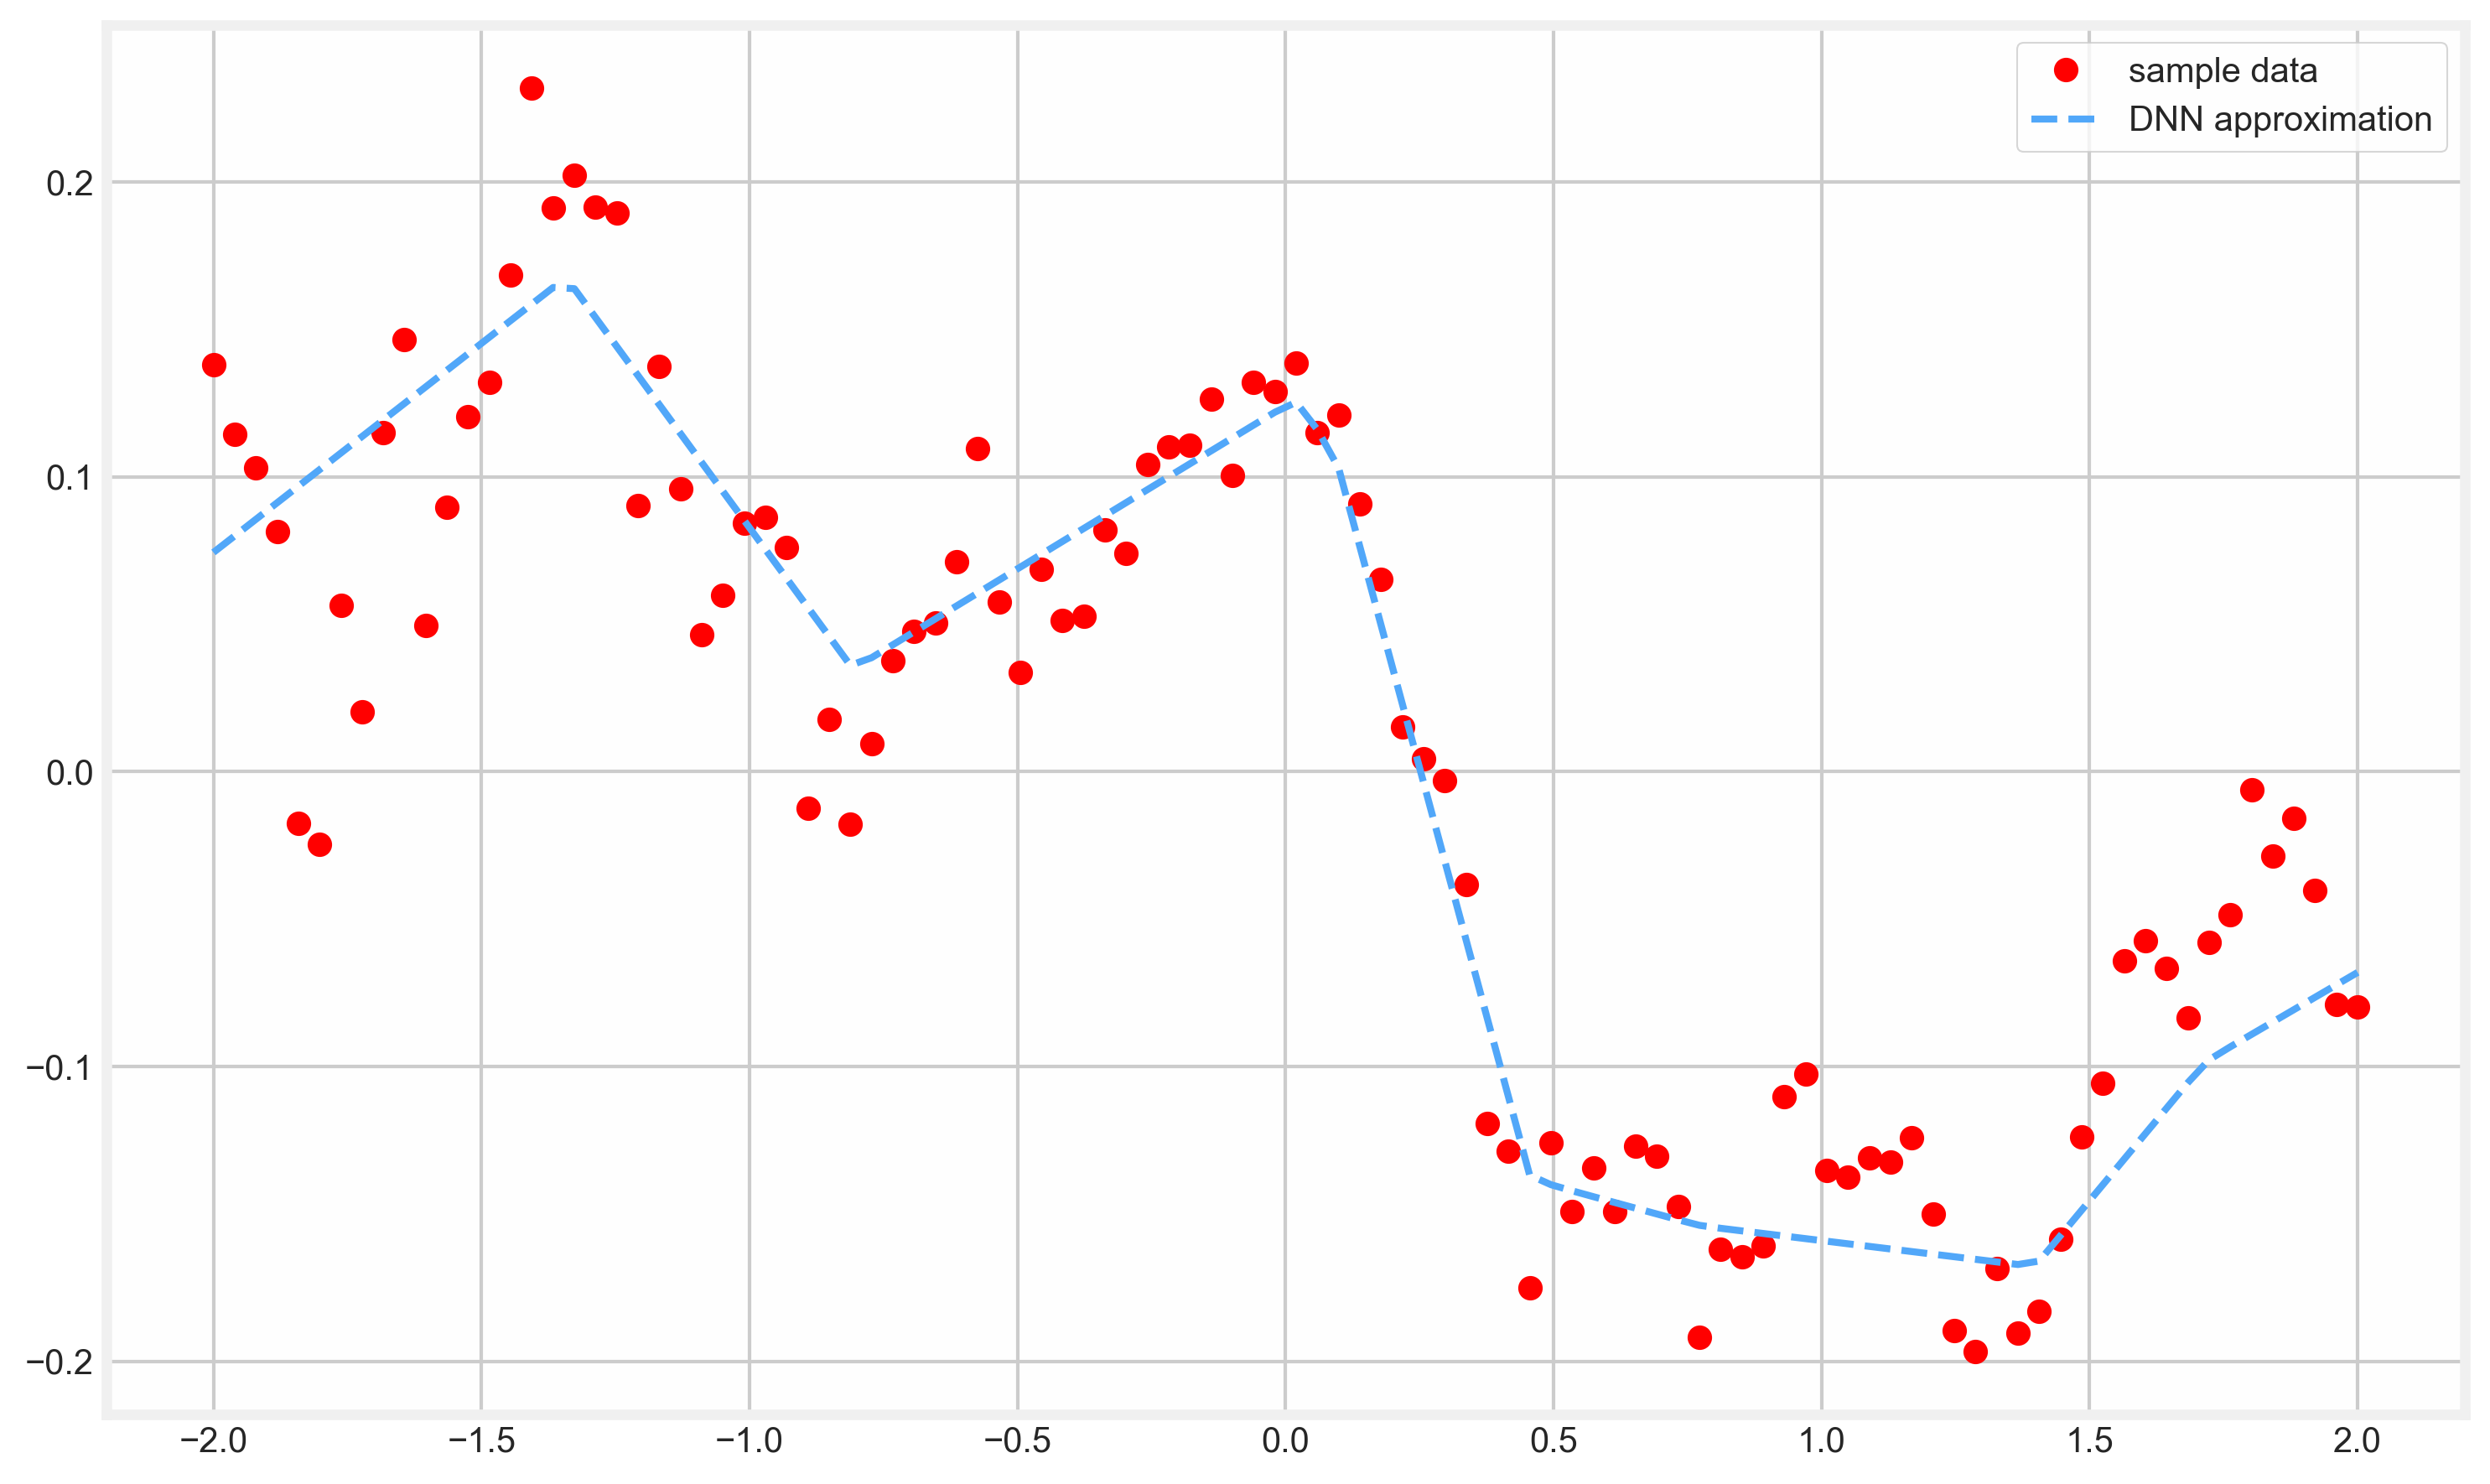

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(f, l, 'ro', label='sample data')
plt.plot(f, p, '--', label='DNN approximation')
plt.legend();

In [25]:
res = pd.DataFrame(hist.history)

In [26]:
res.tail()

loss
1495 0.00185230
1496 0.00167440
1497 0.00147539
1498 0.00131041
1499 0.00162942

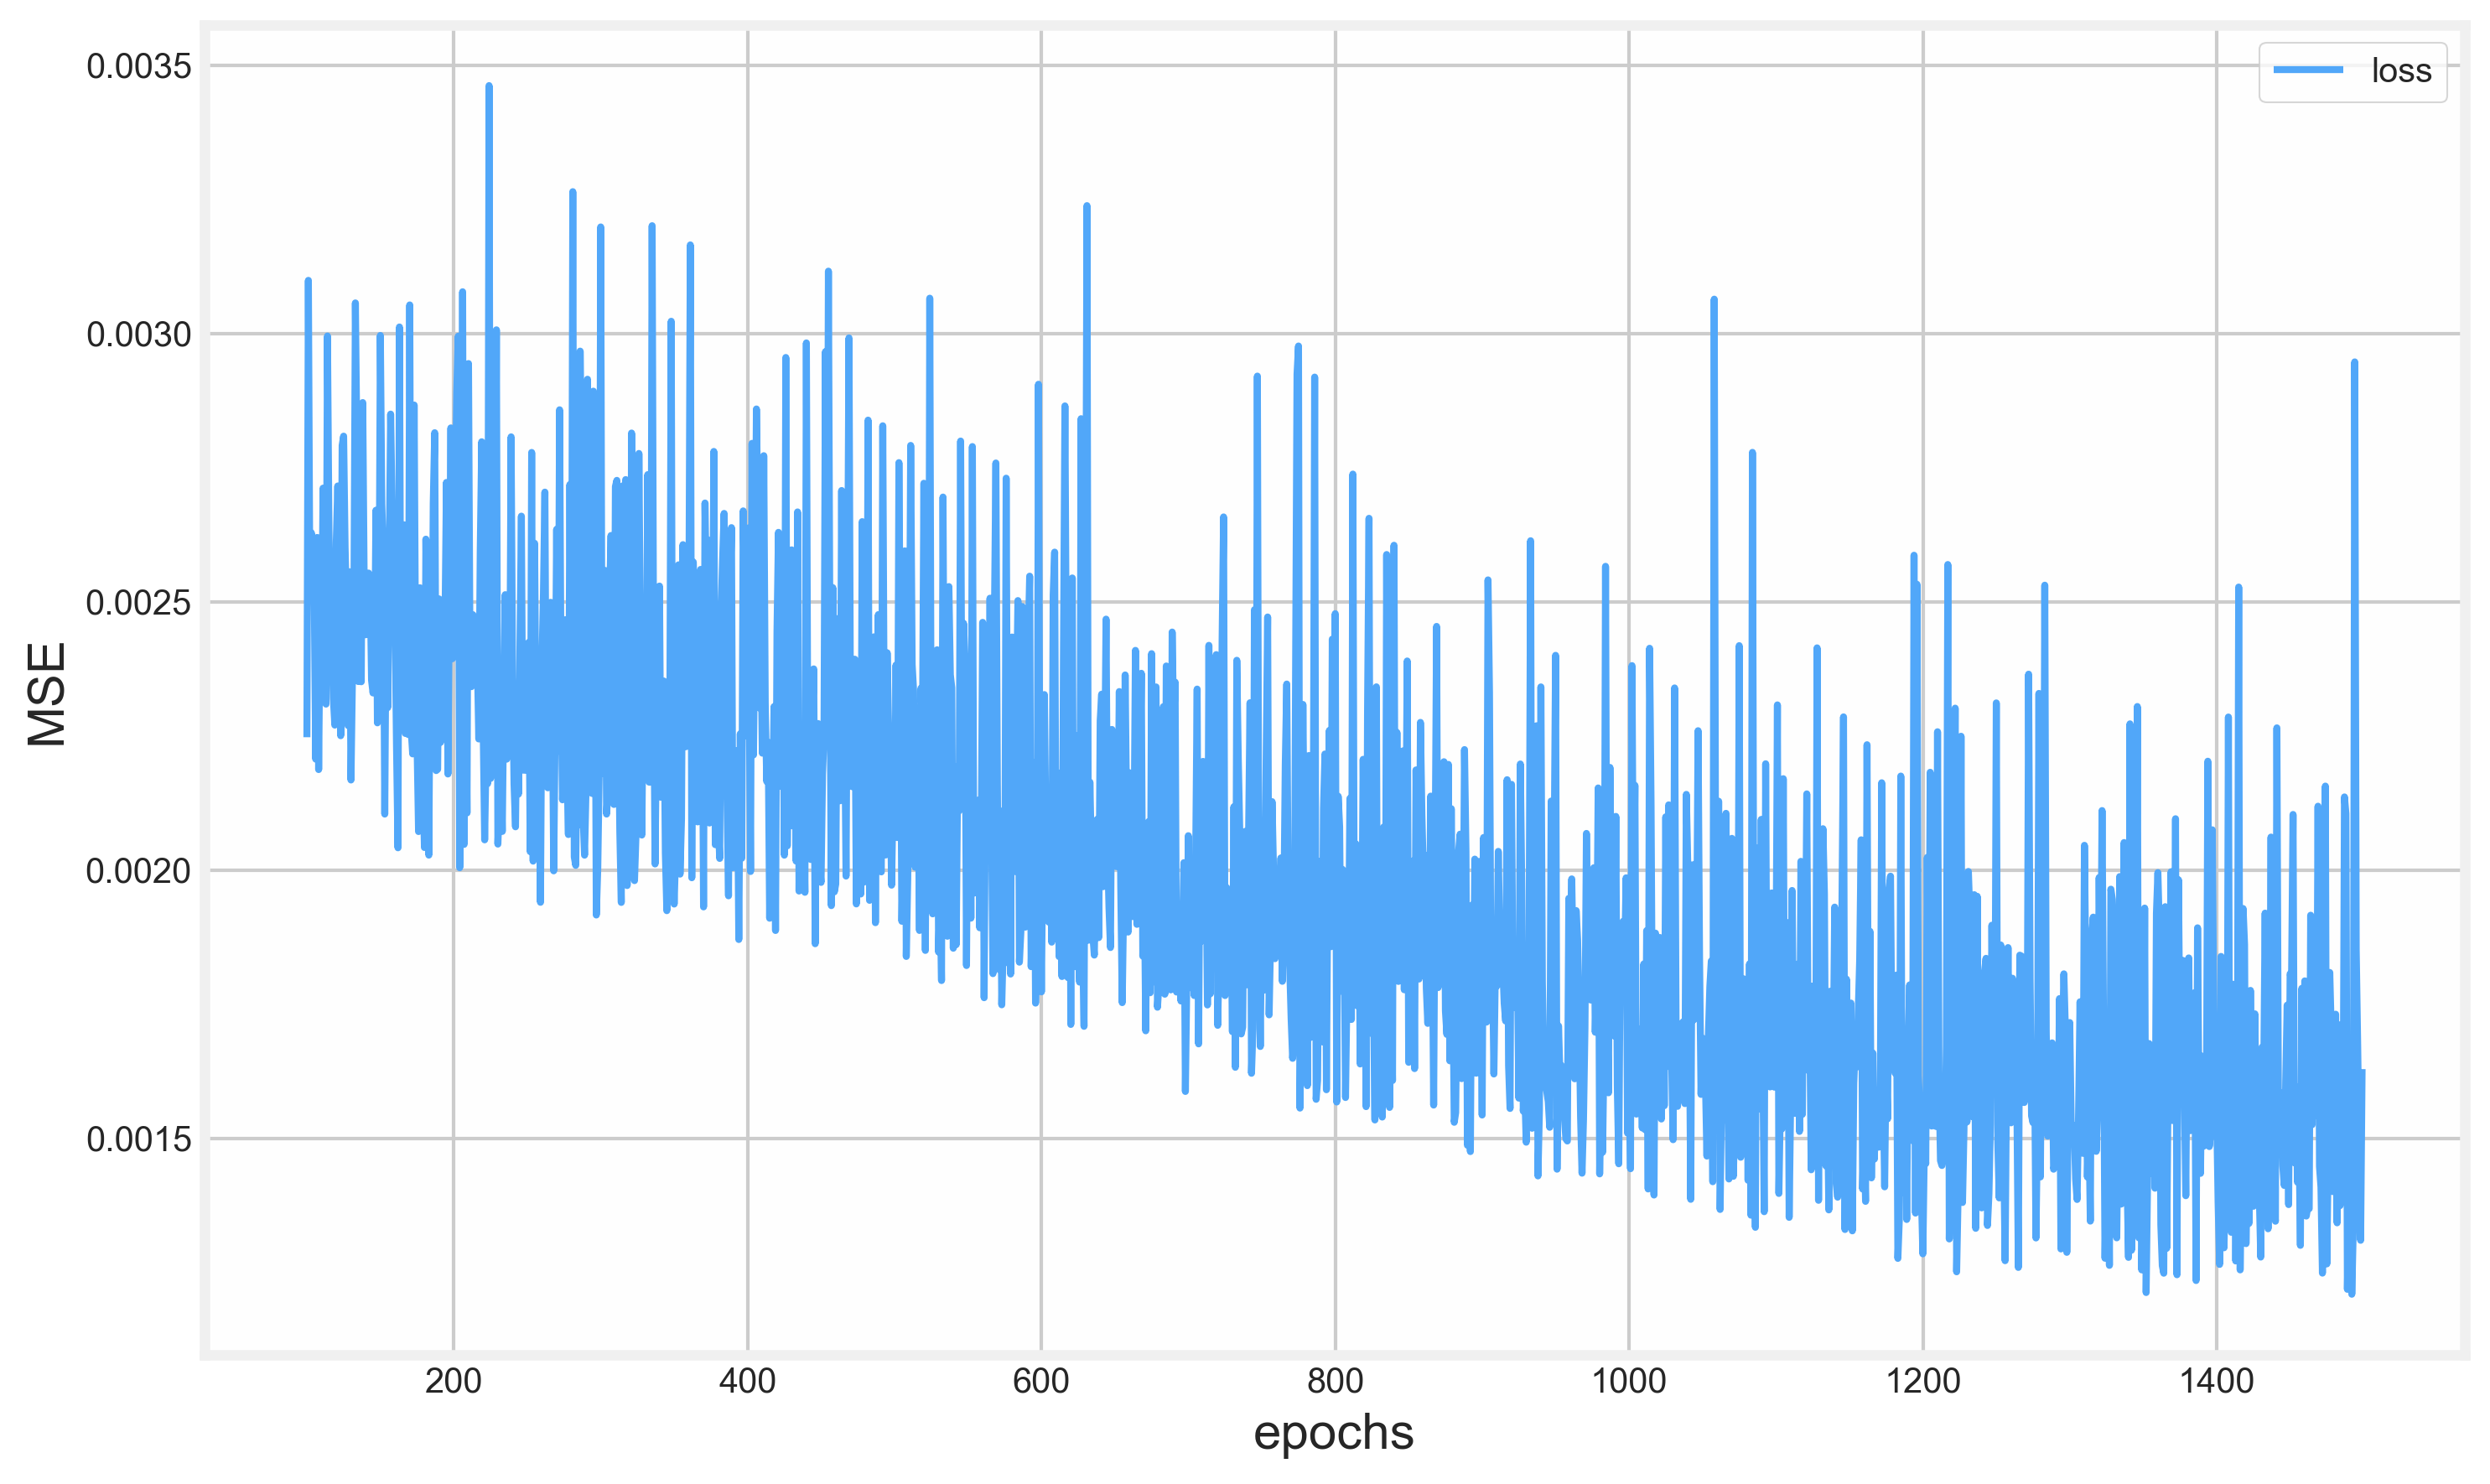

In [27]:
res.iloc[100:].plot(figsize=(10, 6))
plt.ylabel('MSE')
plt.xlabel('epochs');

## Capacity

In [28]:
reg = {}
for d in range(1, 12, 2):
    reg[d] = np.polyfit(f, l, deg=d)
    p = np.polyval(reg[d], f)
    mse = MSE(l, p)
    print(f'{d:2d} | MSE={mse}')

 1 | MSE=0.006011205214862202
 3 | MSE=0.003968681260927775
 5 | MSE=0.0035301184629877576
 7 | MSE=0.0026833411588142106
 9 | MSE=0.0013419574601342848
11 | MSE=0.001010892267137115


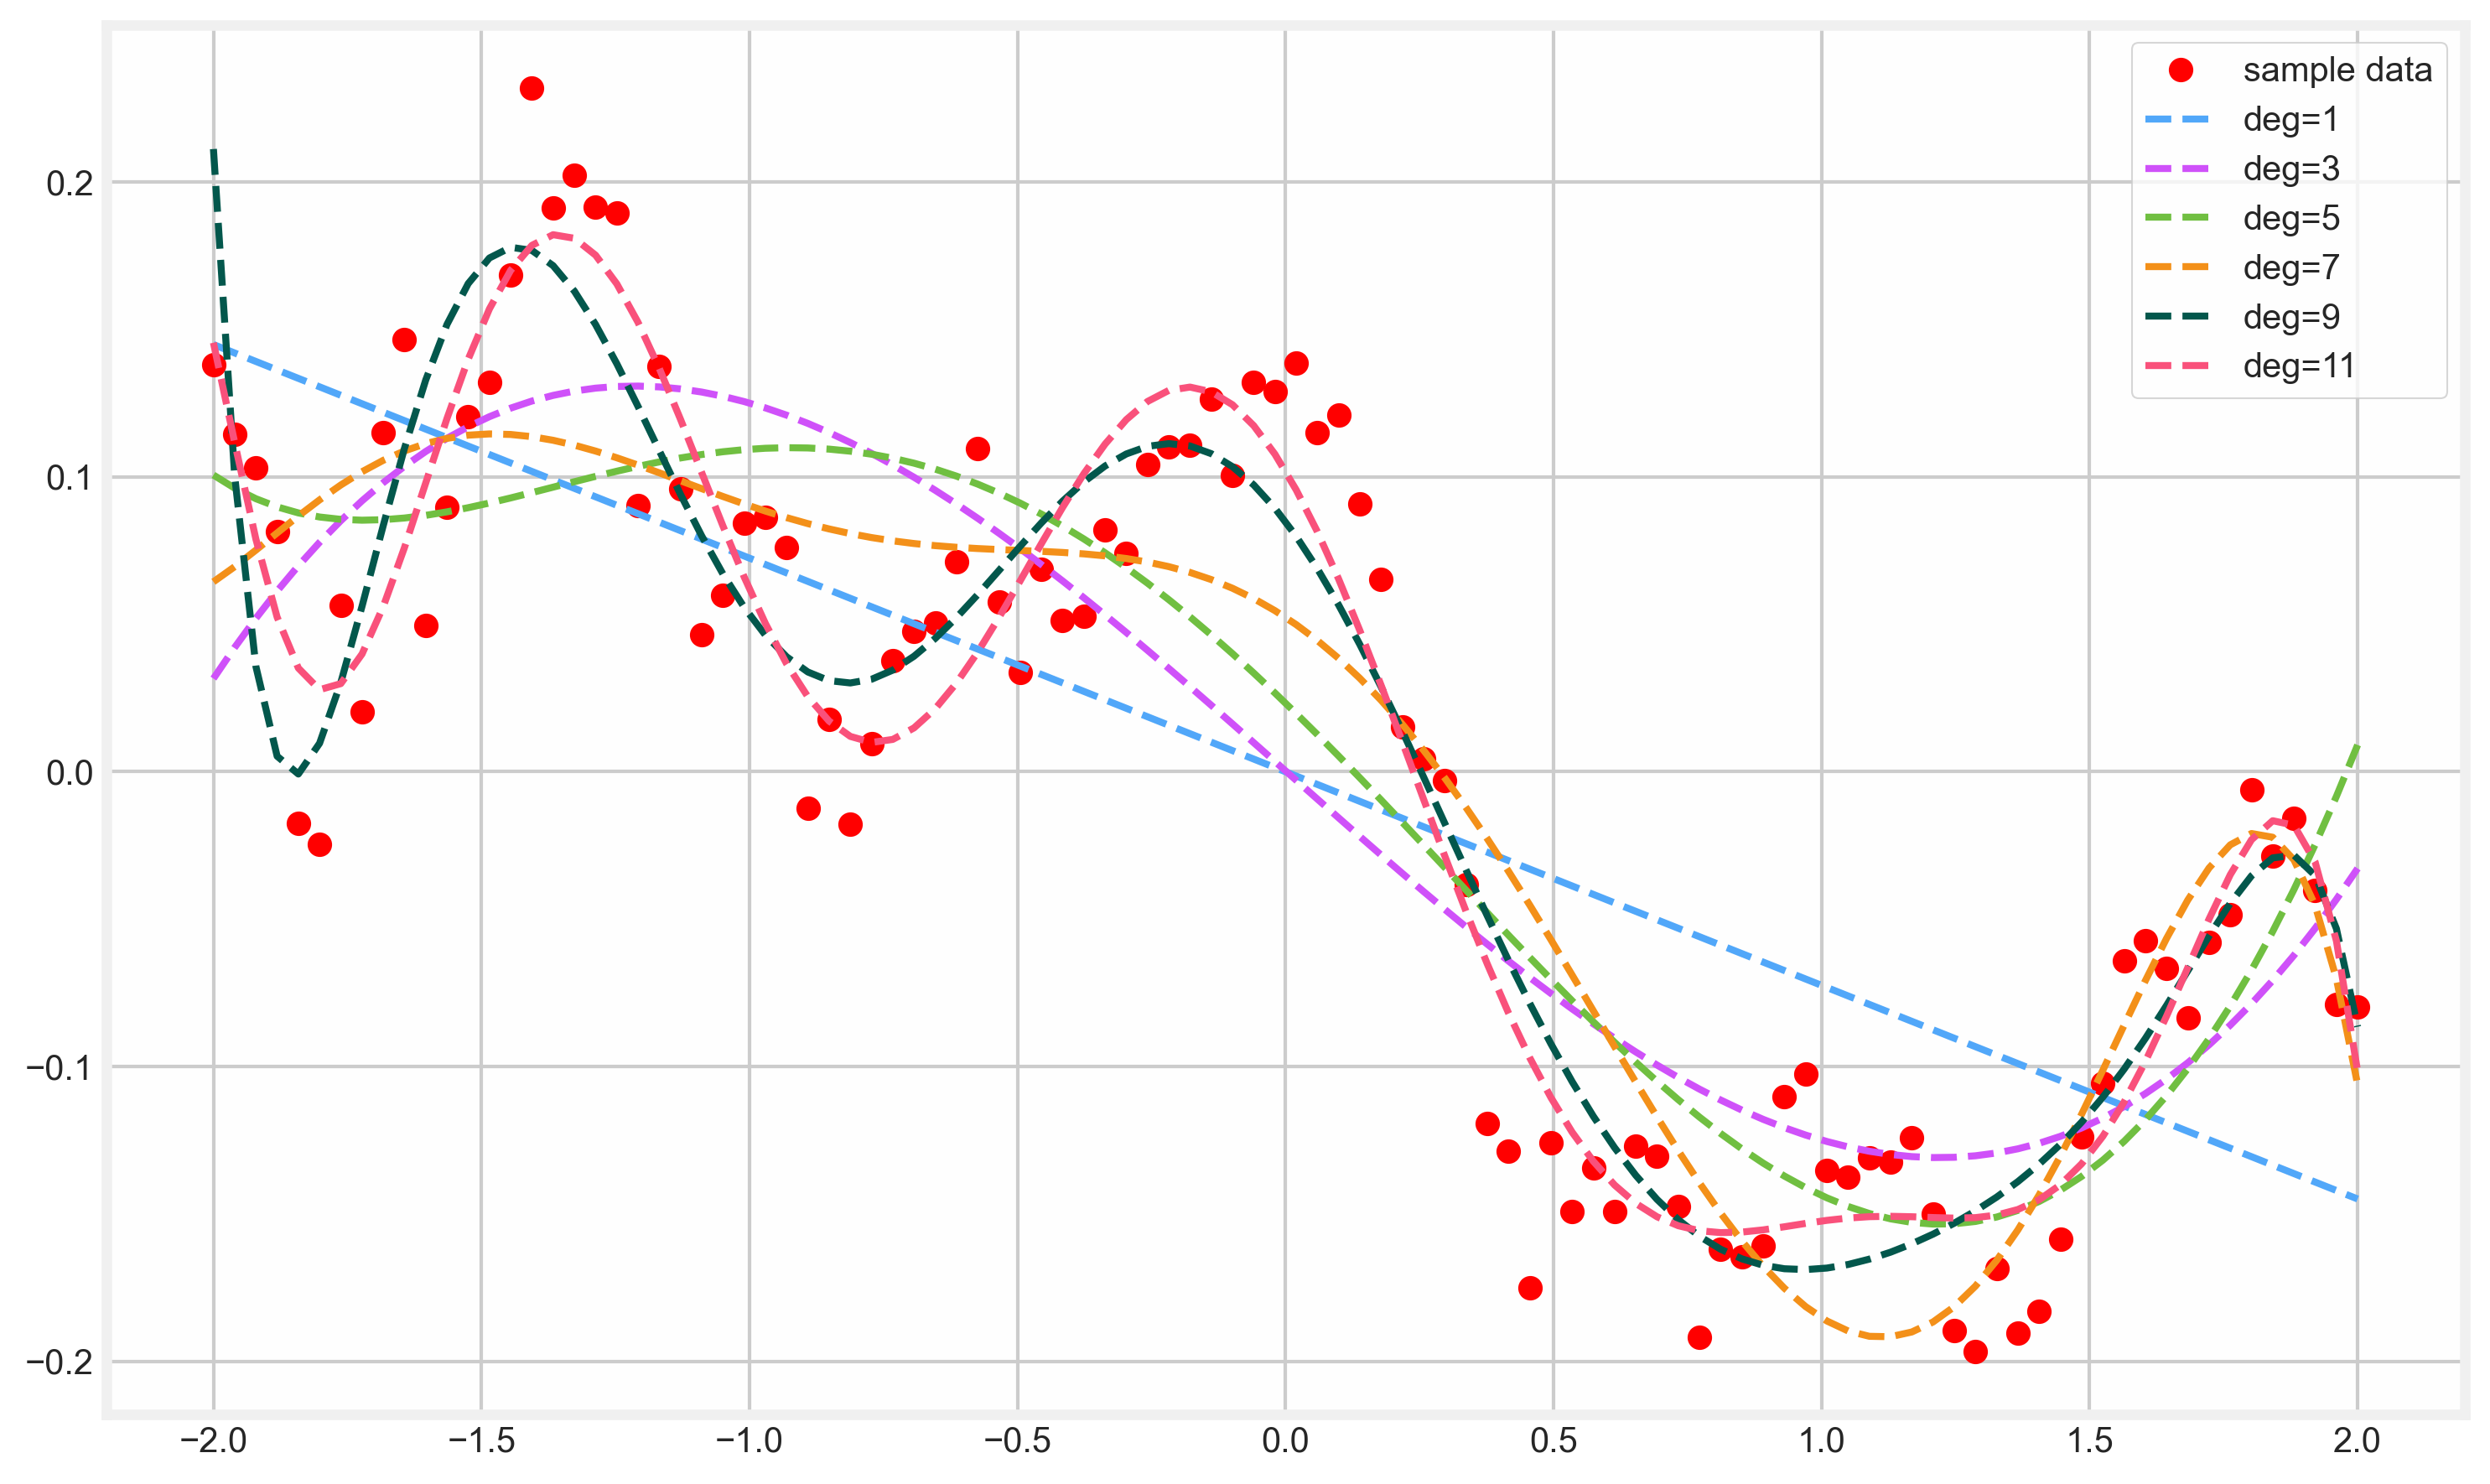

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(f, l, 'ro', label='sample data')
for d in reg:
    p = np.polyval(reg[d], f)
    plt.plot(f, p, '--', label=f'deg={d}')
plt.legend();

In [30]:
def create_dnn_model(hl=1, hu=256):
    ''' Function to create Keras DNN model.
    
    Parameters
    ==========
    hl: int
        number of hidden layers
    hu: int
        number of hidden units (per layer)
    '''
    model = Sequential()
    for _ in range(hl):
        model.add(Dense(hu, activation='relu', input_dim=1))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='rmsprop')
    return model

In [31]:
model = create_dnn_model(3)

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 256)               512       
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 132,353
Trainable params: 132,353
Non-trainable params: 0
_________________________________________________________________


In [33]:
%time model.fit(f, l, epochs=2500, verbose=False)

CPU times: user 29.3 s, sys: 11 s, total: 40.3 s
Wall time: 12.8 s


In [34]:
p = model.predict(f).flatten()

In [35]:
MSE(l, p)

0.0005124627150892627

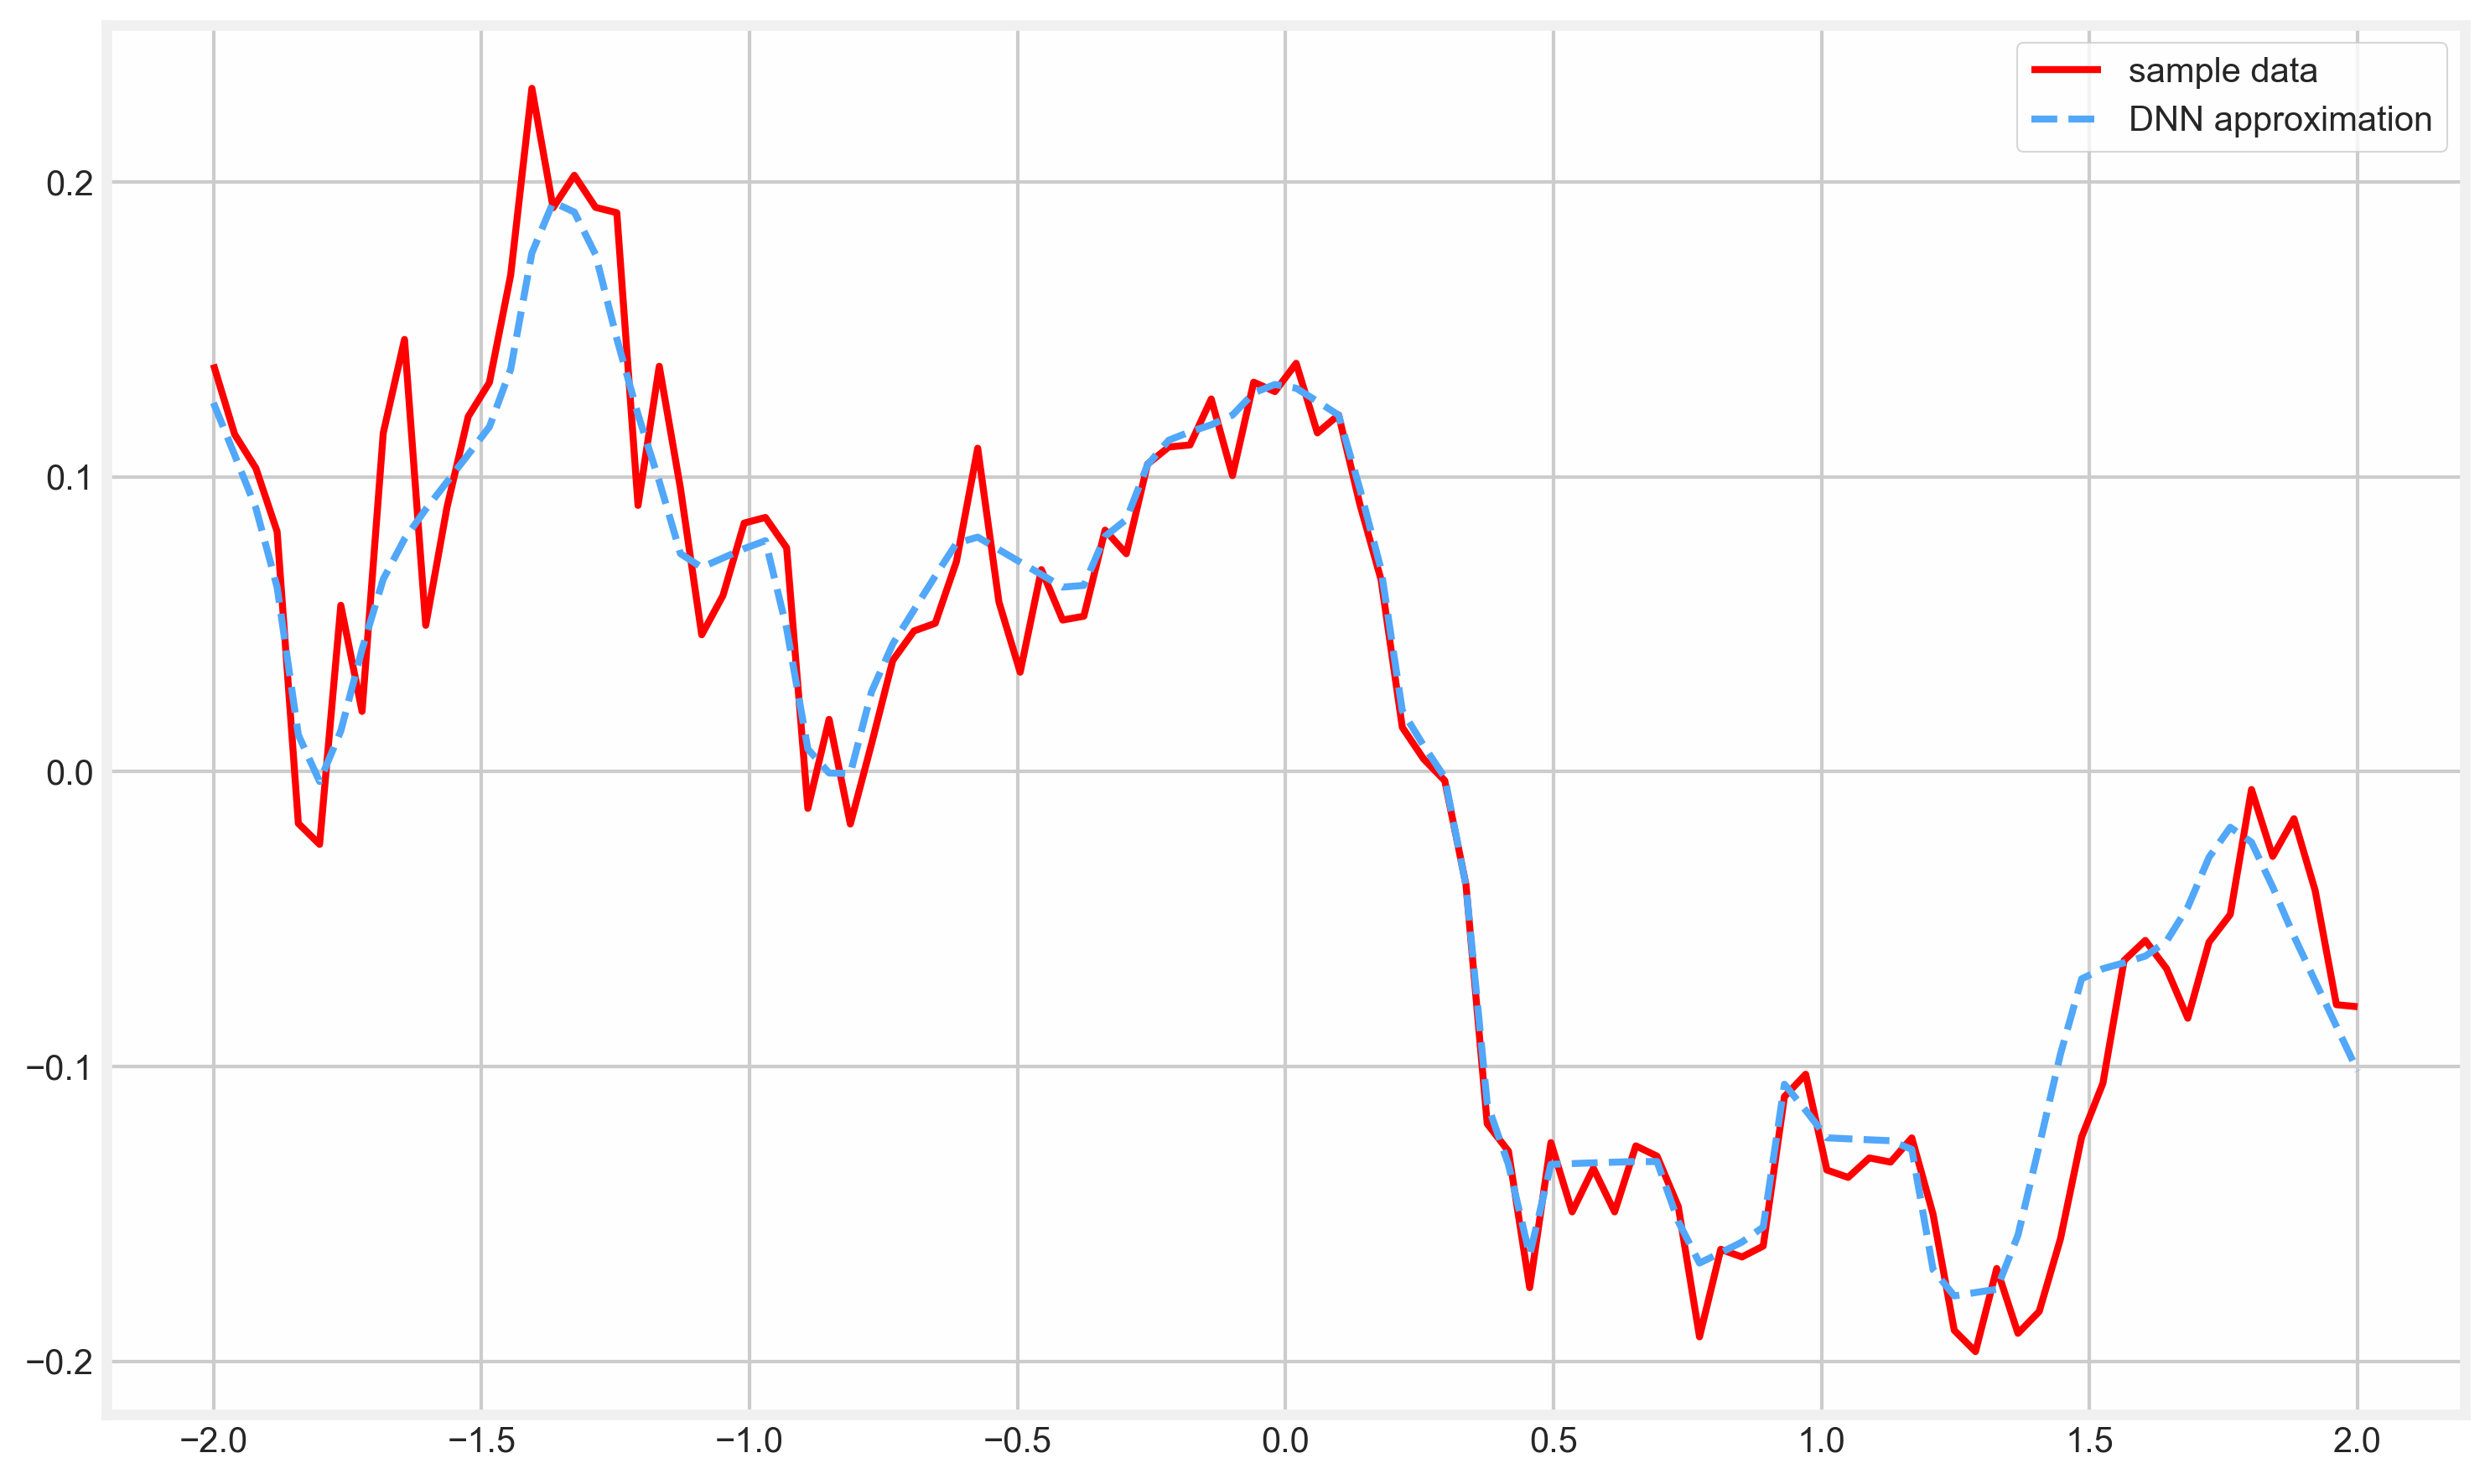

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(f, l, 'r', label='sample data')
plt.plot(f, p, '--', label='DNN approximation')
plt.legend();

## Evaluation

In [37]:
te = int(0.25 * len(f))
va = int(0.25 * len(f))

In [38]:
np.random.seed(100)
ind = np.arange(len(f))
np.random.shuffle(ind)

In [39]:
ind_te = np.sort(ind[:te])
ind_va = np.sort(ind[te:te + va])
ind_tr = np.sort(ind[te + va:])

In [40]:
f_te = f[ind_te]
f_va = f[ind_va]
f_tr = f[ind_tr]

In [41]:
l_te = l[ind_te]
l_va = l[ind_va]
l_tr = l[ind_tr]

In [42]:
reg = {}
mse = {}
for d in range(1, 22, 4):
    reg[d] = np.polyfit(f_tr, l_tr, deg=d)
    p = np.polyval(reg[d], f_tr)
    mse_tr = MSE(l_tr, p)
    p = np.polyval(reg[d], f_va)
    mse_va = MSE(l_va, p)
    mse[d] = (mse_tr, mse_va)
    print(f'{d:2d} | MSE_tr={mse_tr:7.5f} | MSE_va={mse_va:7.5f}')

 1 | MSE_tr=0.00640 | MSE_va=0.00610
 5 | MSE_tr=0.00390 | MSE_va=0.00315
 9 | MSE_tr=0.00117 | MSE_va=0.00177
13 | MSE_tr=0.00073 | MSE_va=0.00116
17 | MSE_tr=0.00062 | MSE_va=0.00112
21 | MSE_tr=0.00050 | MSE_va=0.01651


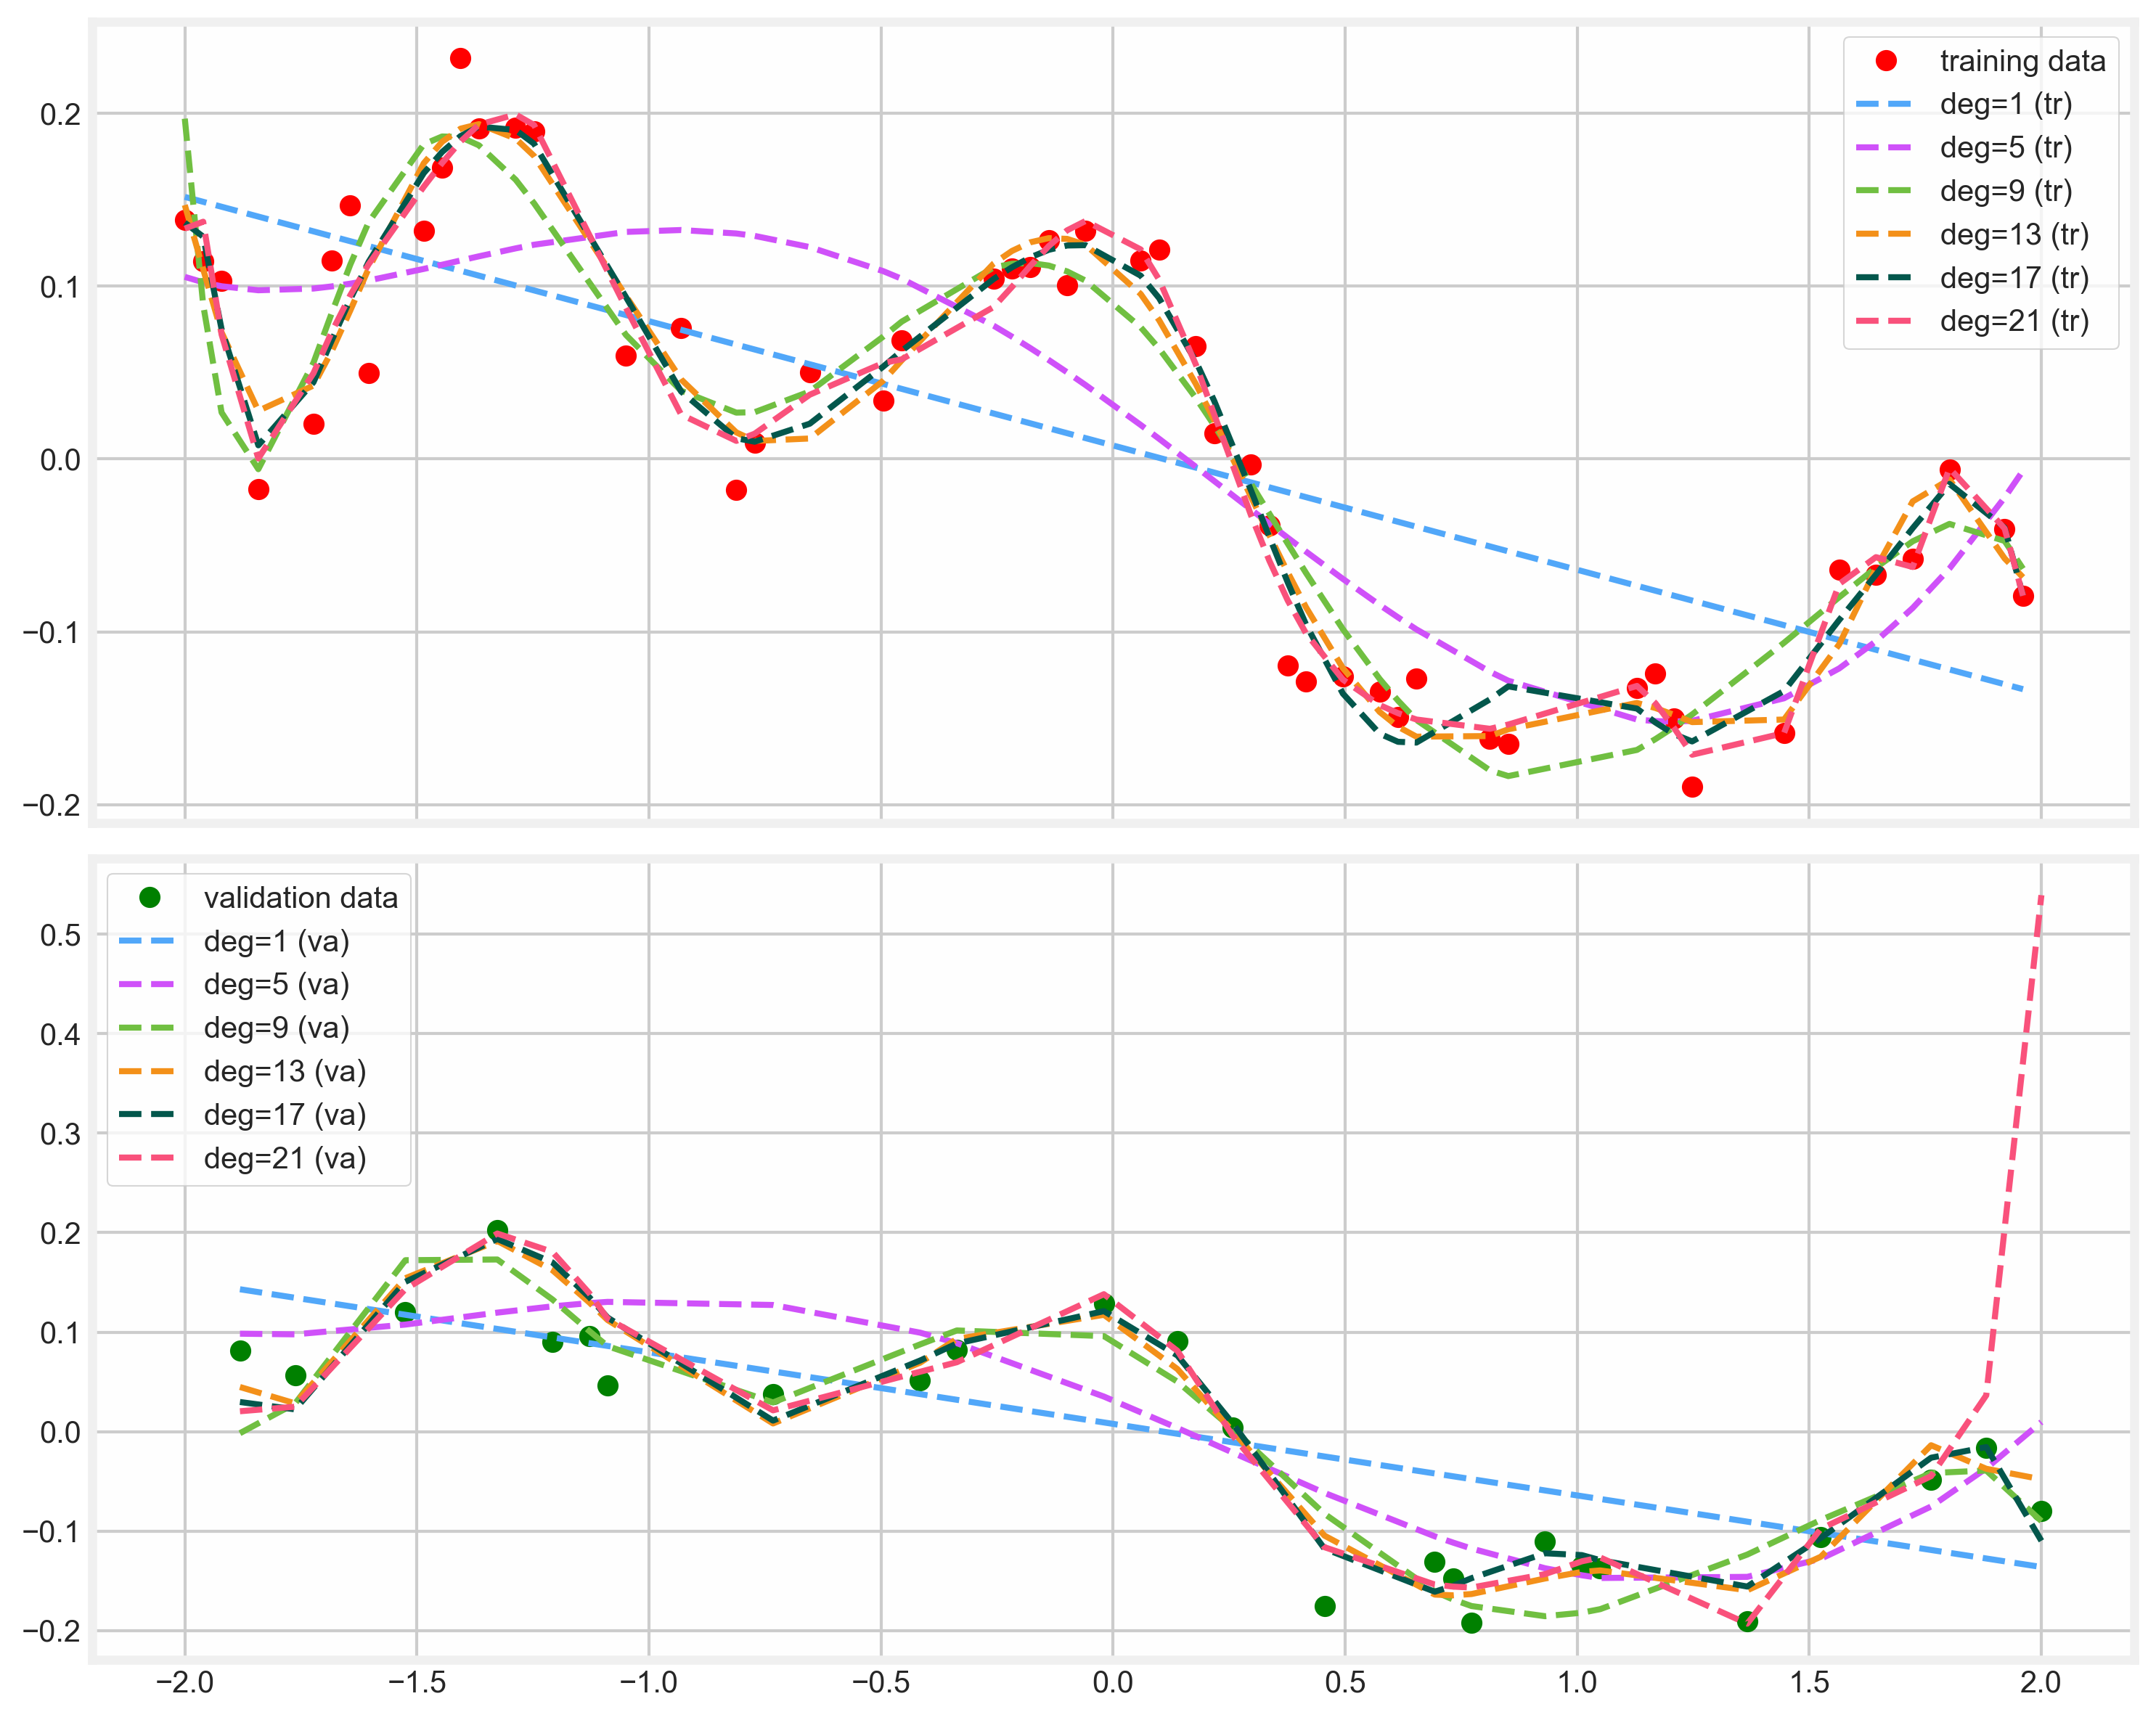

In [43]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
ax[0].plot(f_tr, l_tr, 'ro', label='training data')
ax[1].plot(f_va, l_va, 'go', label='validation data')
for d in reg:
    p = np.polyval(reg[d], f_tr)
    ax[0].plot(f_tr, p, '--', label=f'deg={d} (tr)')
    p = np.polyval(reg[d], f_va)
    plt.plot(f_va, p, '--', label=f'deg={d} (va)')
ax[0].legend()
ax[1].legend();

In [44]:
model = create_dnn_model(2, 256)

## Early Stopping

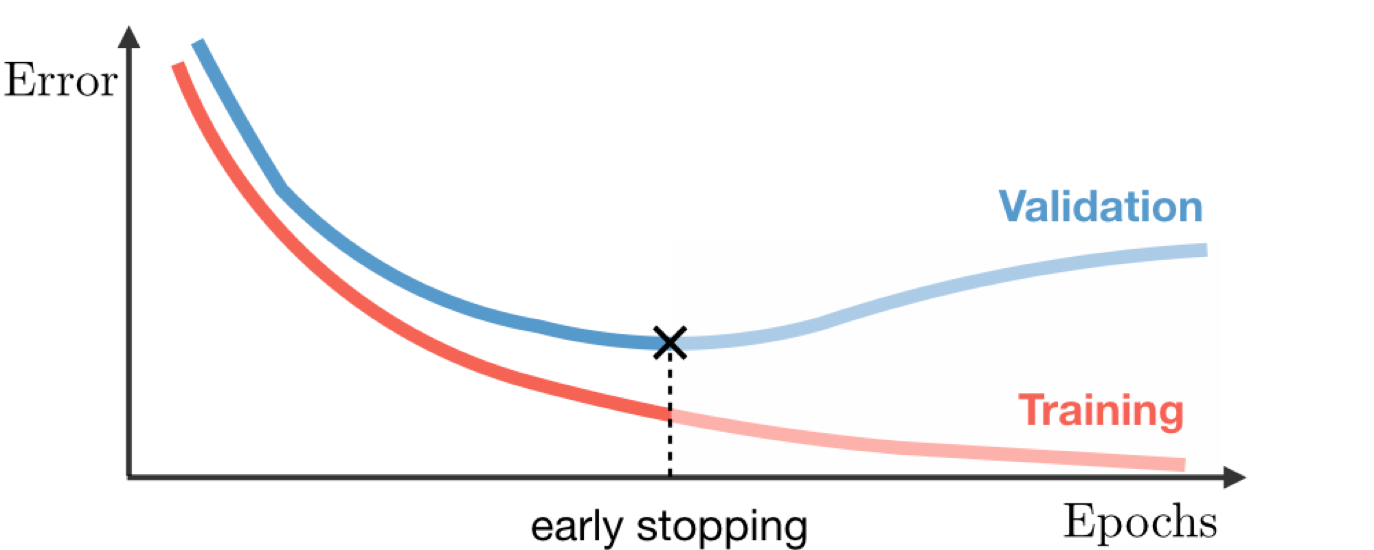

In [45]:
callbacks = [EarlyStopping(monitor='loss',
                           patience=100,
                          restore_best_weights=True)]

In [46]:
%%time
hist = model.fit(f_tr, l_tr, epochs=3000, verbose=False,
          validation_data=(f_va, l_va),
          callbacks=callbacks)

CPU times: user 26.4 s, sys: 6.52 s, total: 33 s
Wall time: 22.3 s


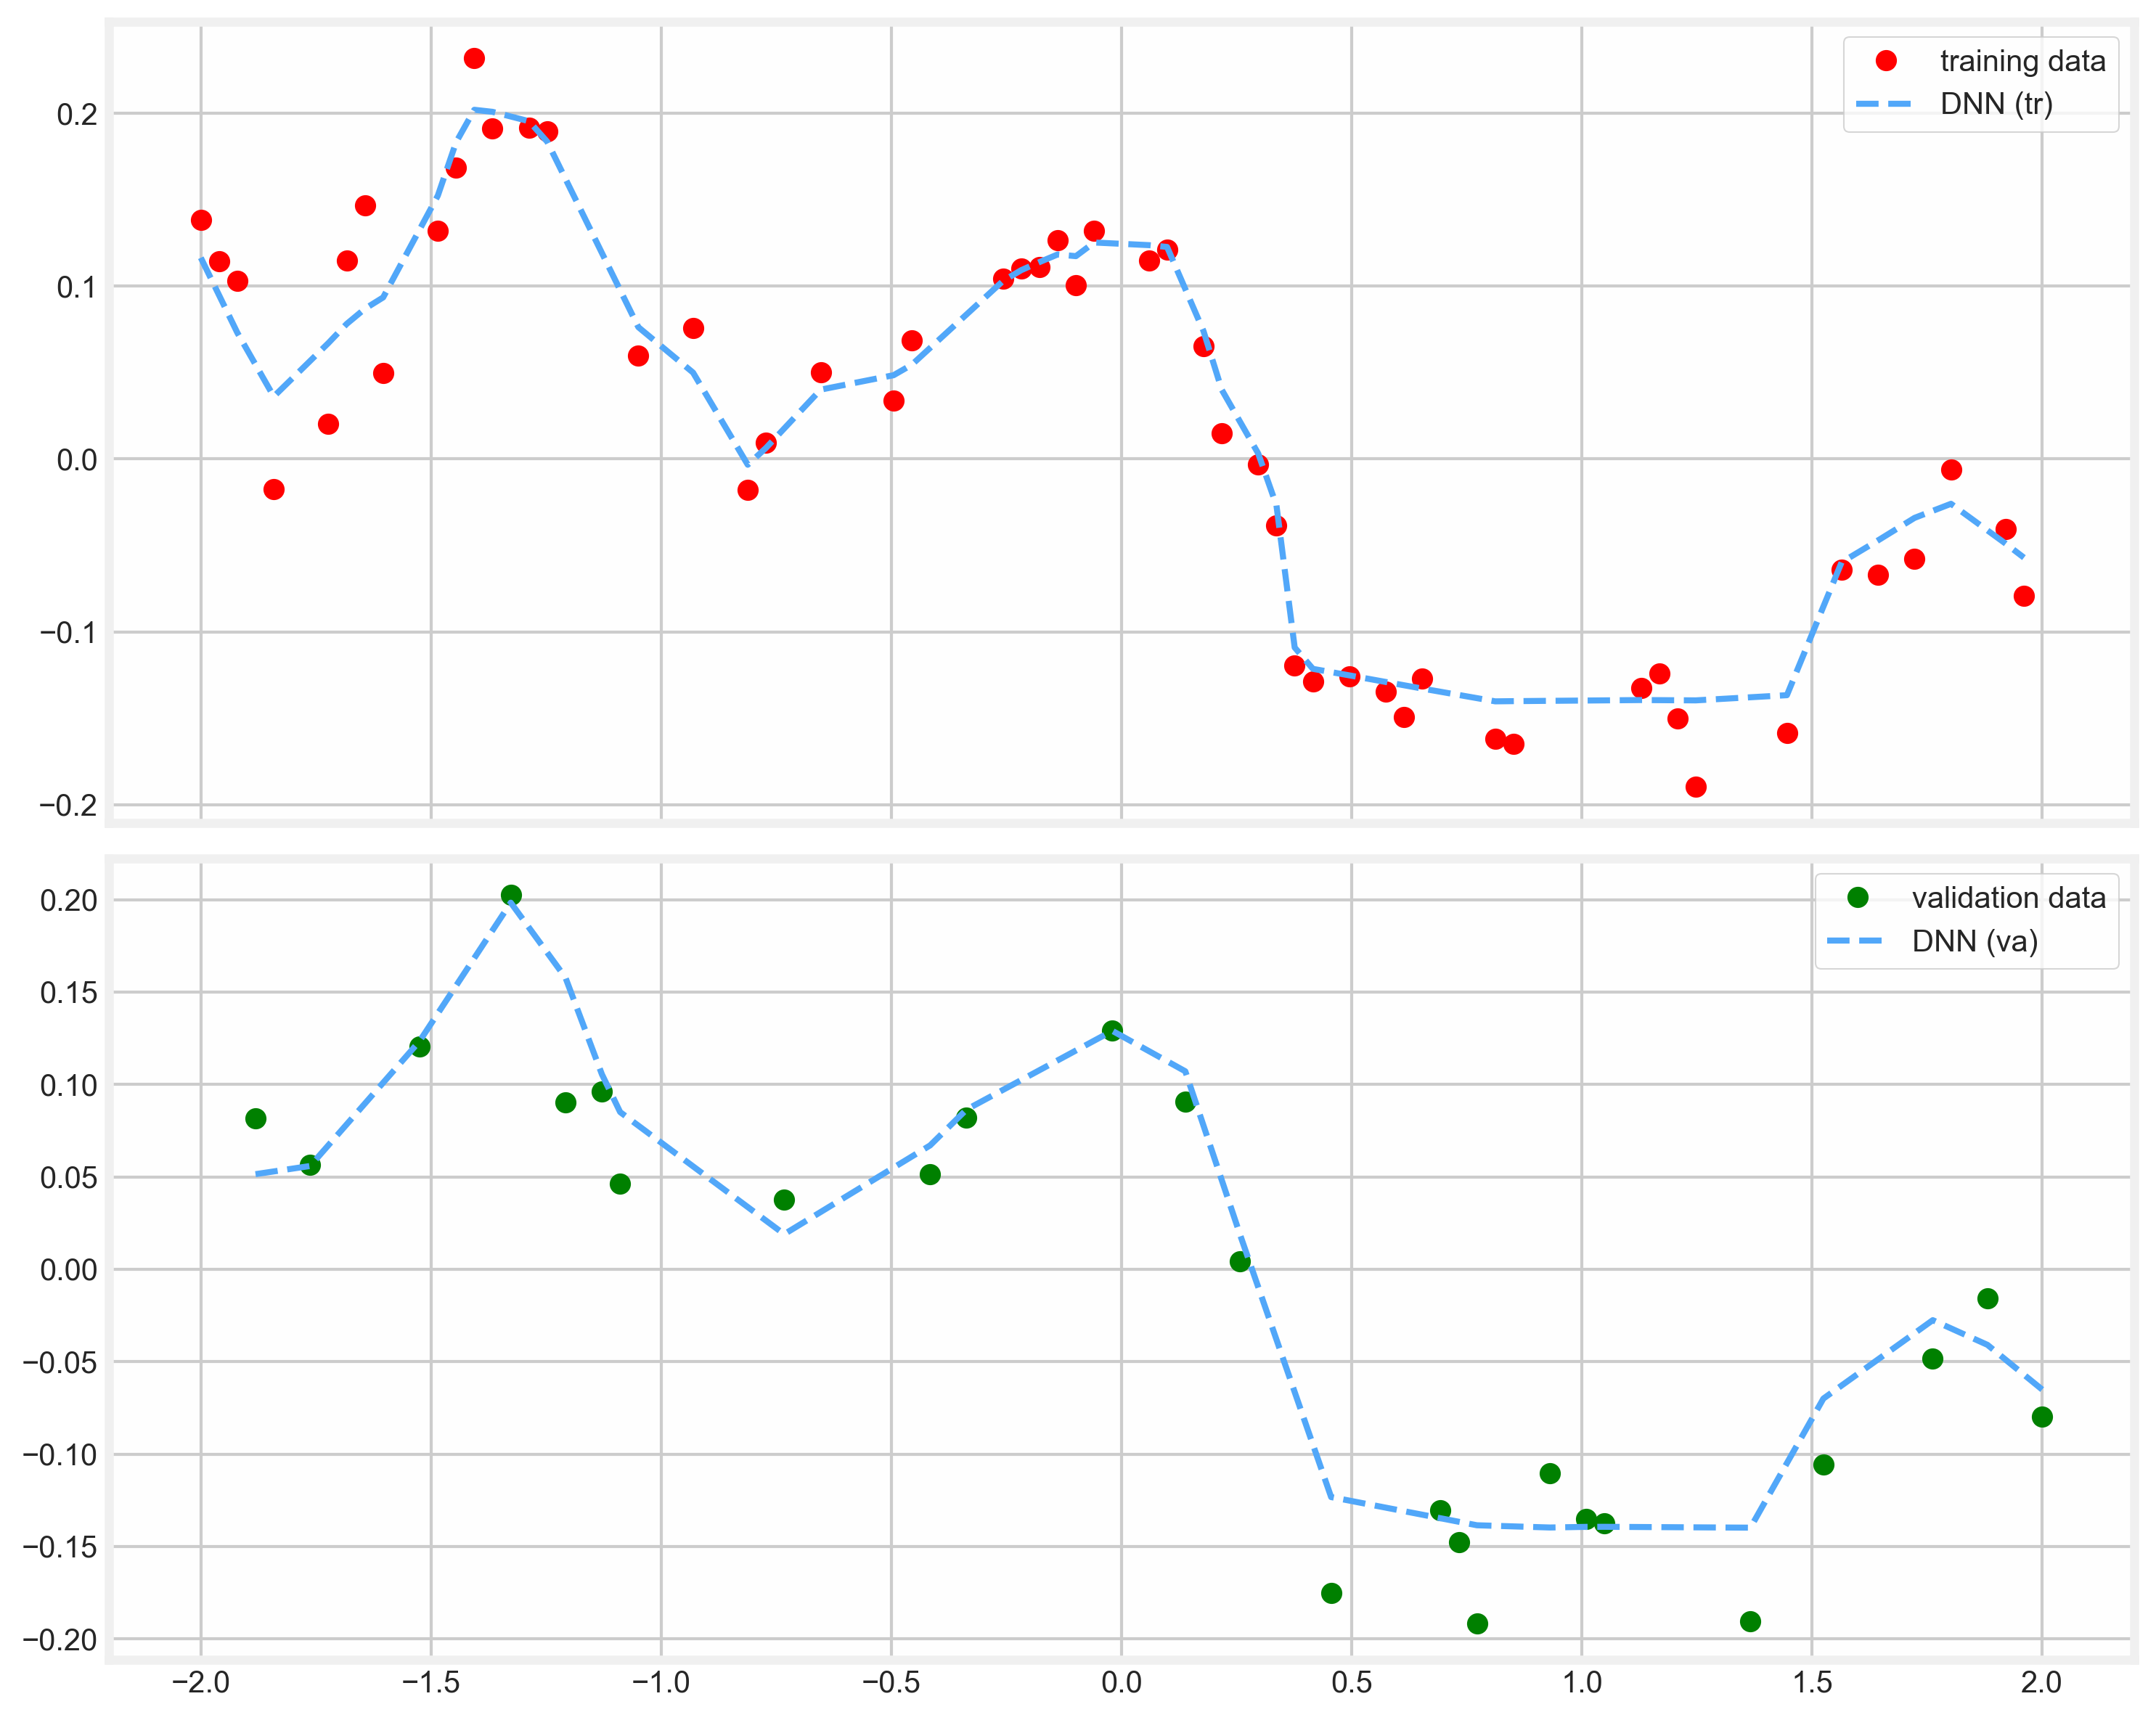

In [47]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10, 8))
ax[0].plot(f_tr, l_tr, 'ro', label='training data')
p = model.predict(f_tr)
ax[0].plot(f_tr, p, '--', label=f'DNN (tr)')
ax[0].legend()
ax[1].plot(f_va, l_va, 'go', label='validation data')
p = model.predict(f_va)
ax[1].plot(f_va, p, '--', label=f'DNN (va)')
ax[1].legend();

In [48]:
res = pd.DataFrame(hist.history)

In [49]:
res.tail()

loss   val_loss
1425 0.00061855 0.00099056
1426 0.00066285 0.00092071
1427 0.00067011 0.00094761
1428 0.00049432 0.00088625
1429 0.00047821 0.00080177

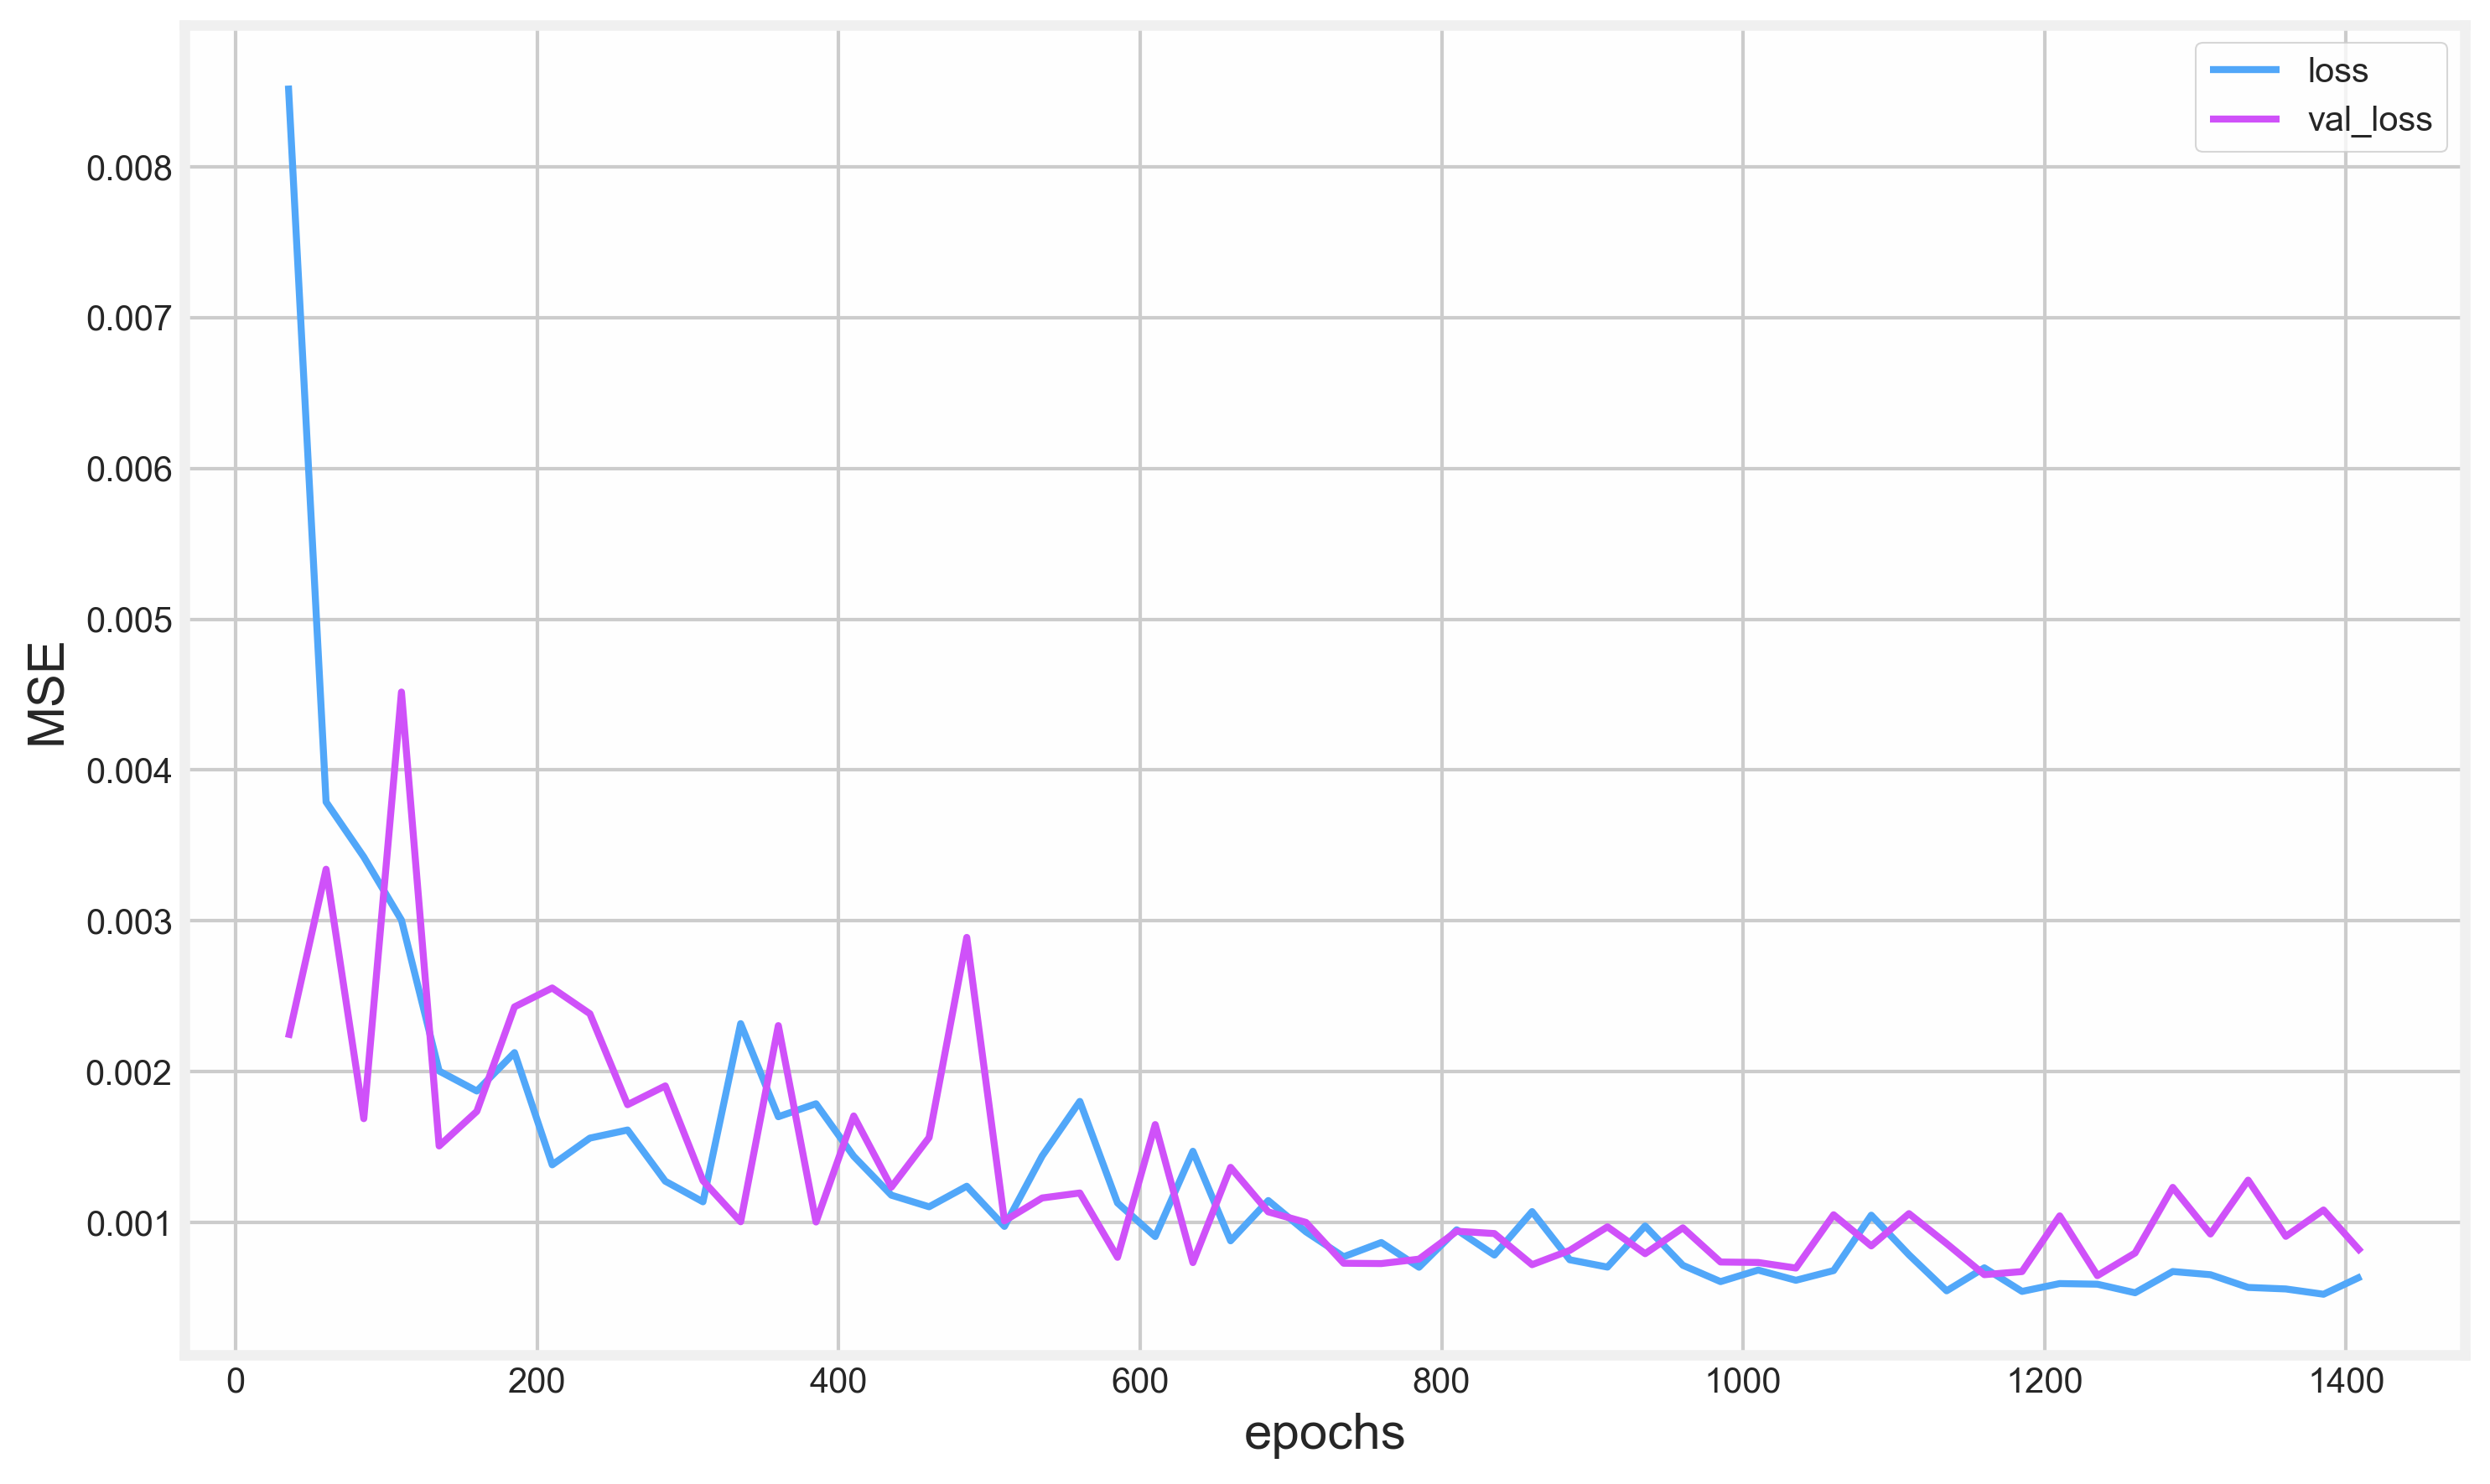

In [50]:
res.iloc[35::25].plot(figsize=(10, 6))
plt.ylabel('MSE')
plt.xlabel('epochs');

In [51]:
p_ols = np.polyval(reg[5], f_te)
p_dnn = model.predict(f_te).flatten()

In [52]:
MSE(l_te, p_ols)

0.0037988199492463167

In [53]:
MSE(l_te, p_dnn)

0.0010033262333661993

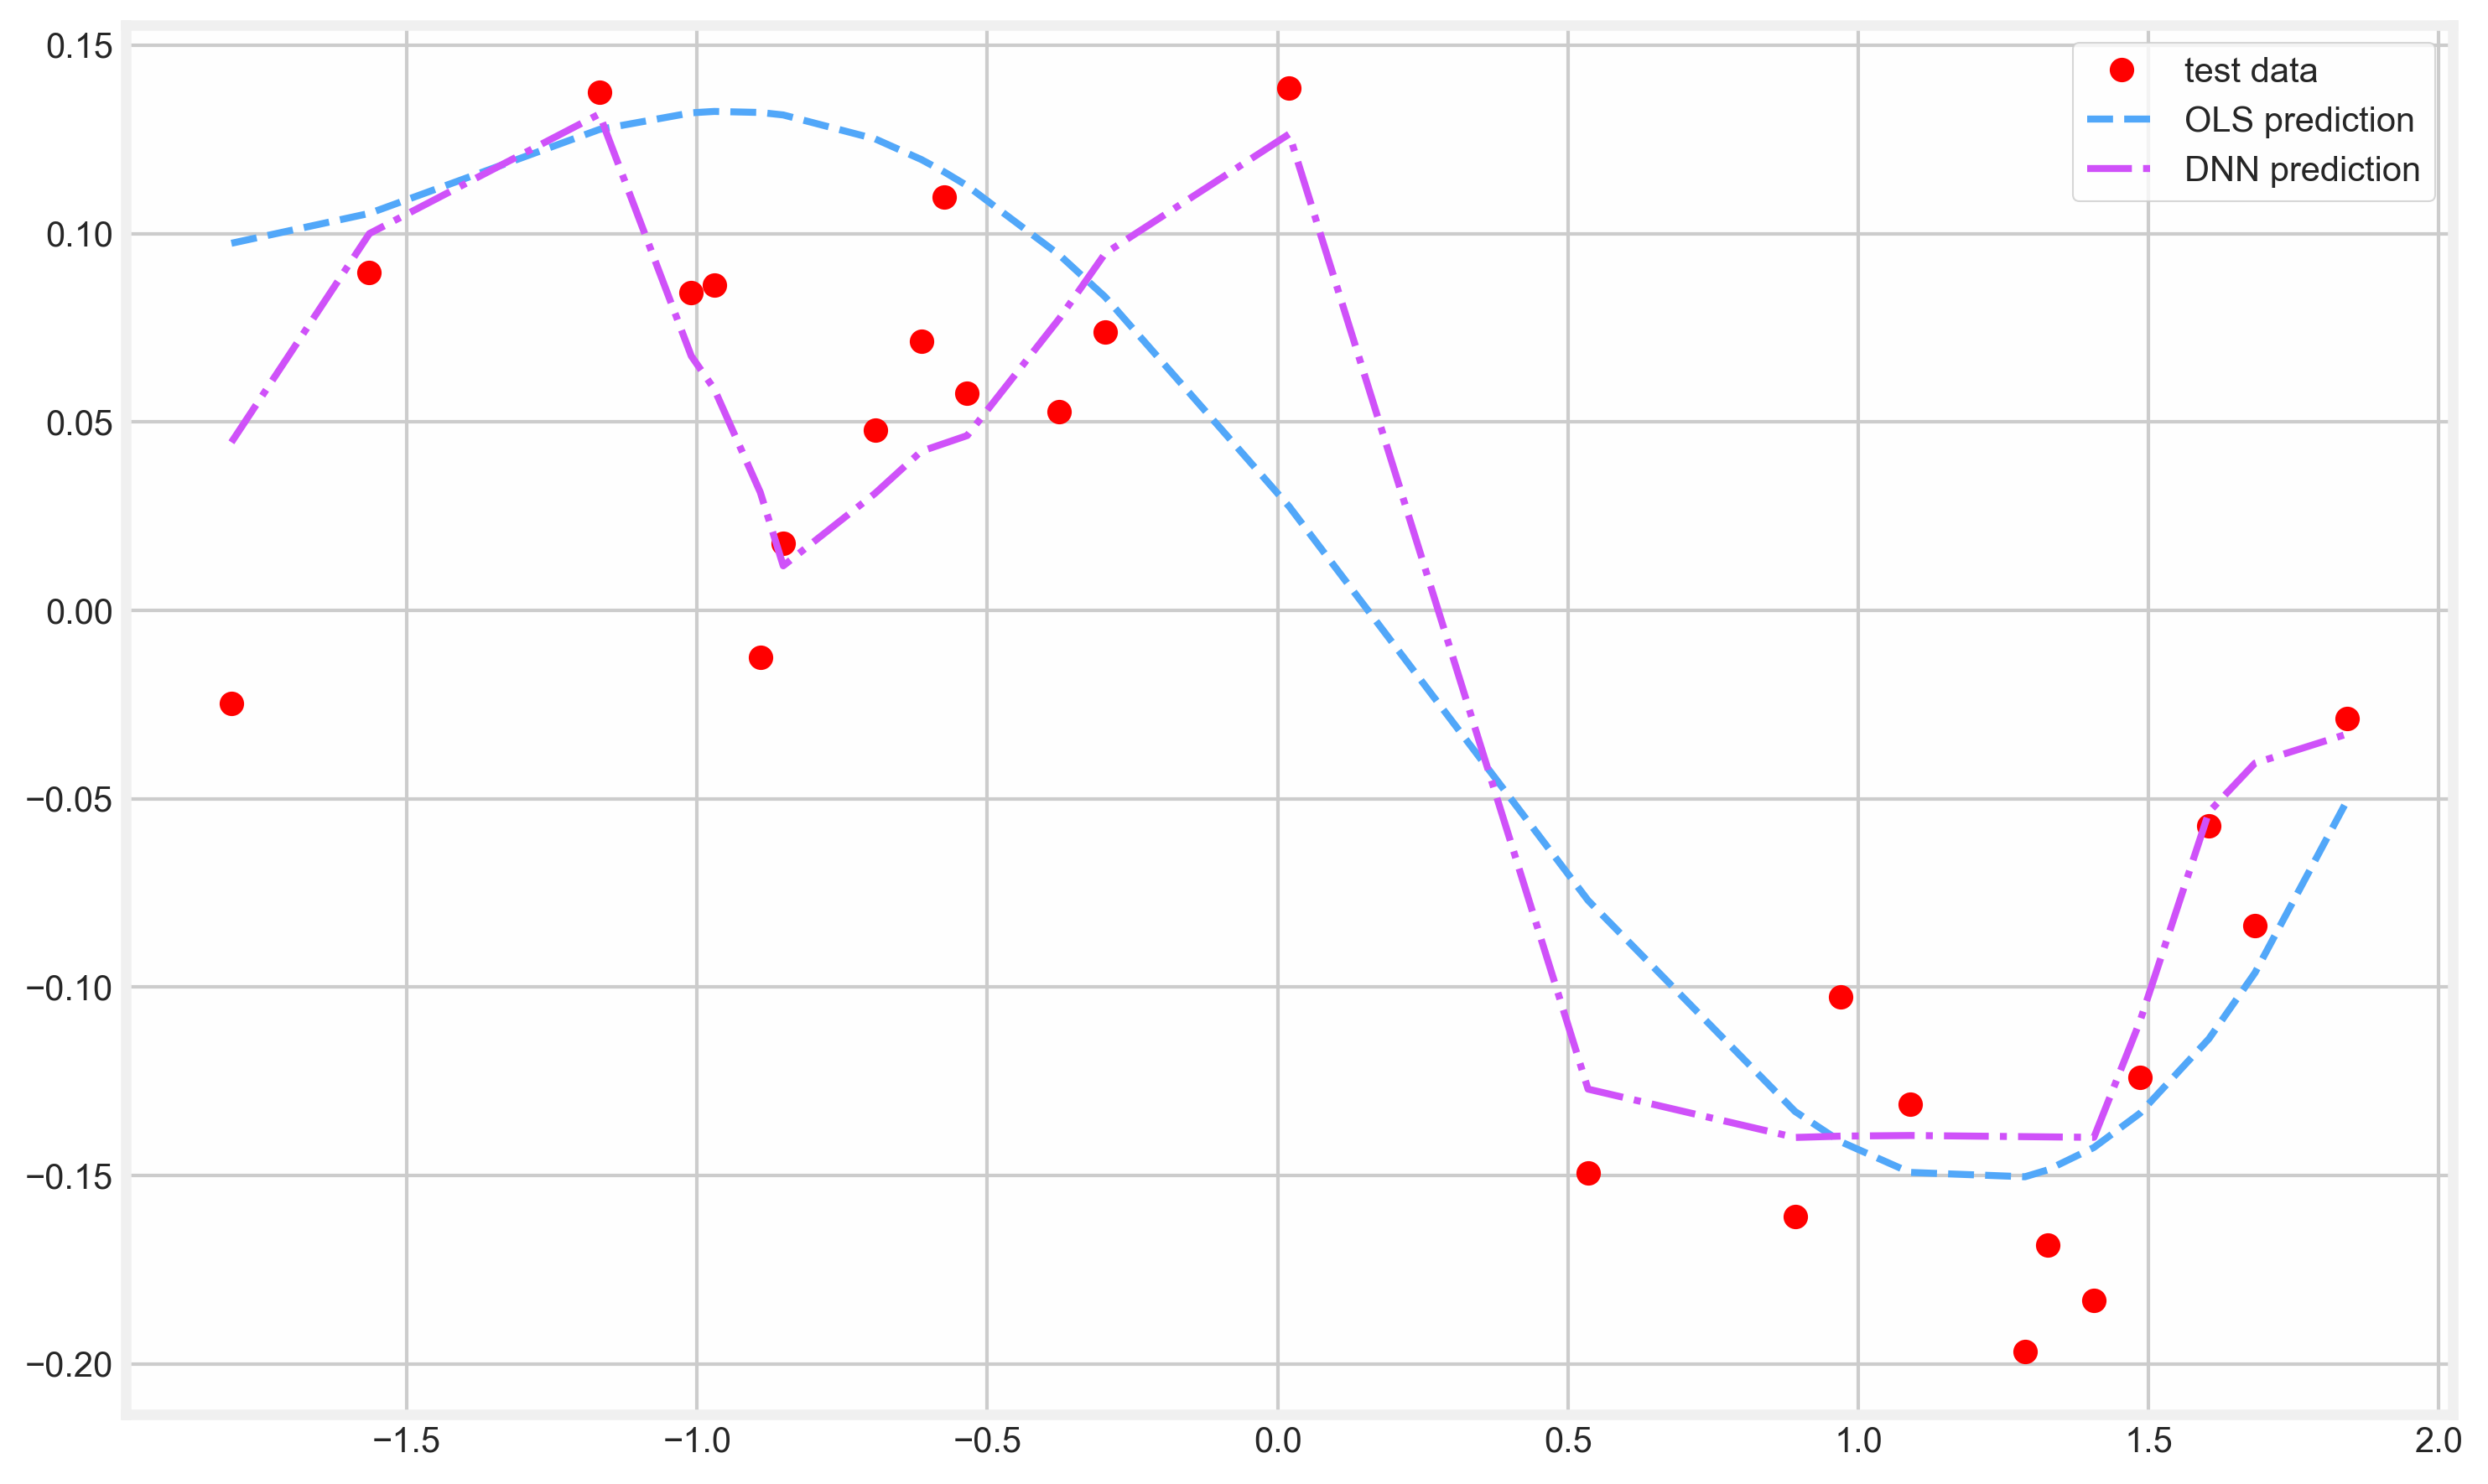

In [54]:
plt.figure(figsize=(10, 6))
plt.plot(f_te, l_te, 'ro', label='test data')
plt.plot(f_te, p_ols, '--', label='OLS prediction')
plt.plot(f_te, p_dnn, '-.', label='DNN prediction');
plt.legend();

## Bias & Variance

Bias-variance tradeoff is a fundamental concept in machine learning, in a nutshell:

- Bias refers to the error due to overly simplistic assumptions in the learning algorithm, leading it to underfit the data.

- Variance refers to the error due to too much complexity in the learning algorithm, causing it to be sensitive to small fluctuations in the training data, leading it to overfit.

__Tradeoff__: Increasing the complexity of a model (reducing bias) will typically increase its variance. Conversely, reducing the model's complexity (increasing bias) will reduce its variance. The tradeoff represents the balance between these two errors, with the goal being to minimize the total error.

In [55]:
f_tr = f[:20:2]
l_tr = l[:20:2]

In [56]:
f_va = f[1:20:2]
l_va = l[1:20:2]

In [57]:
reg_b = np.polyfit(f_tr, l_tr, deg=1)

In [58]:
reg_v = np.polyfit(f_tr, l_tr, deg=9, full=True)[0]

In [59]:
f_ = np.linspace(f_tr.min(), f_va.max(), 75)

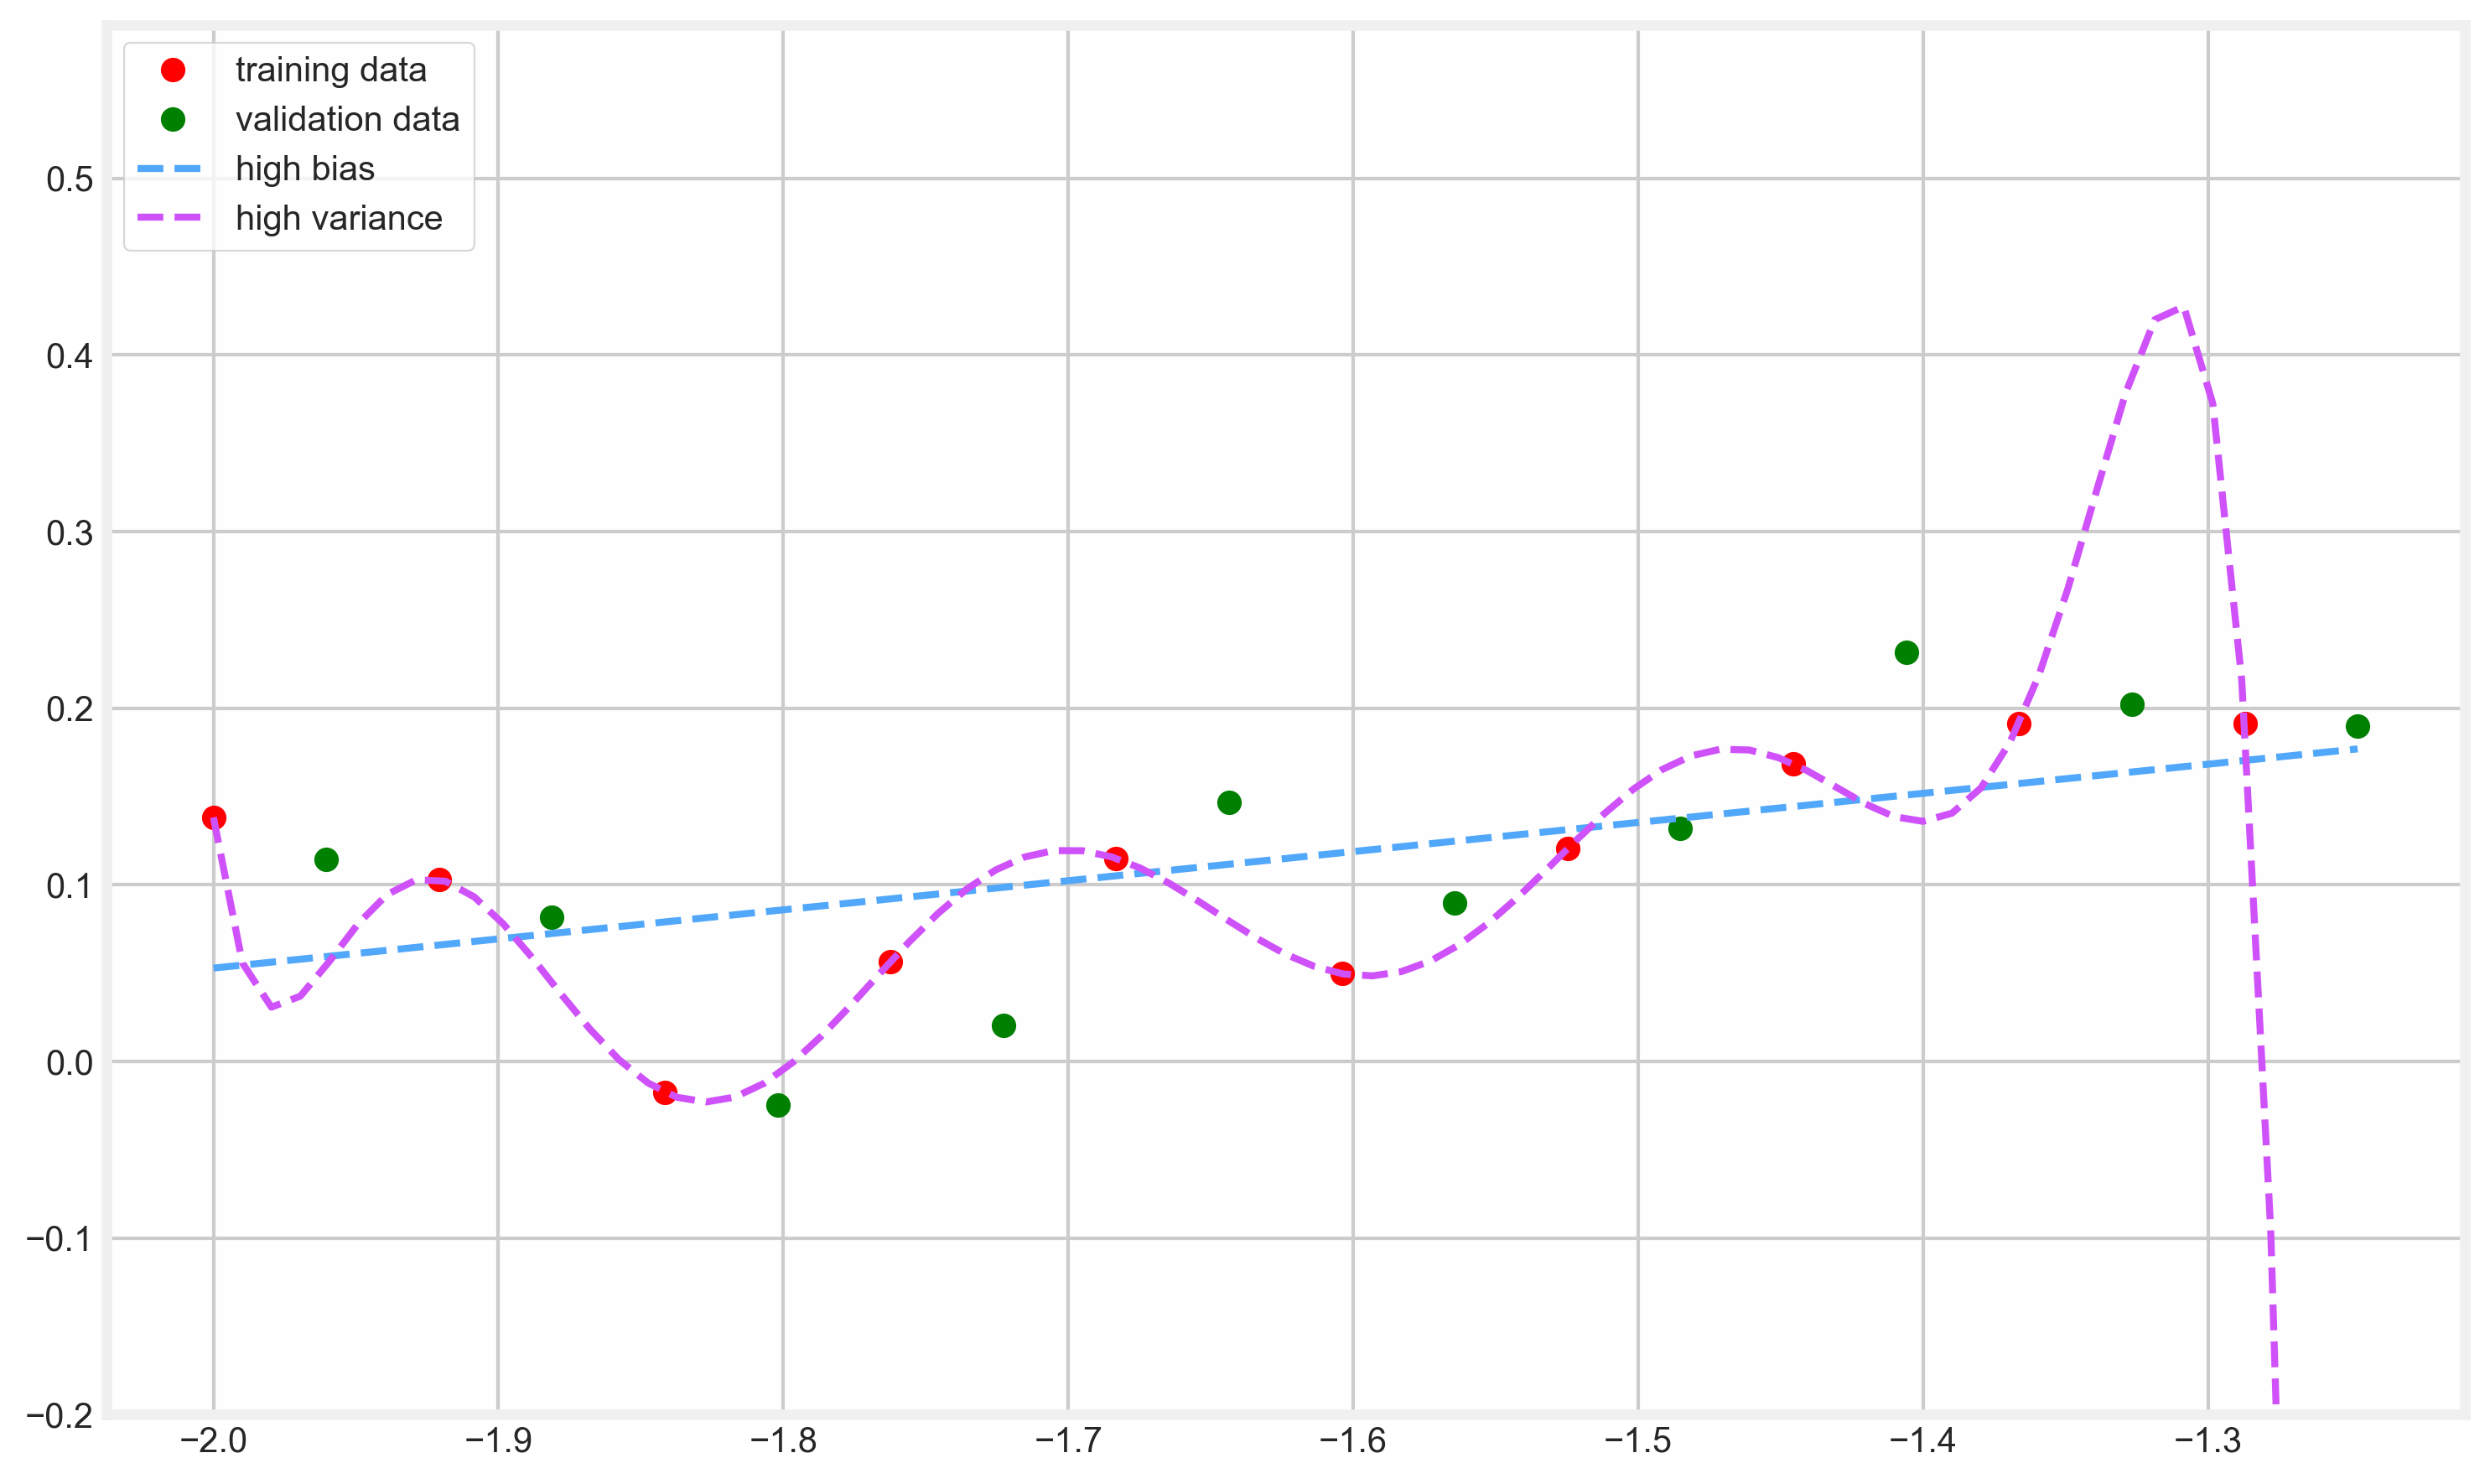

In [60]:
plt.figure(figsize=(10, 6))
plt.plot(f_tr, l_tr, 'ro', label='training data')
plt.plot(f_va, l_va, 'go', label='validation data')
plt.plot(f_, np.polyval(reg_b, f_), '--', label='high bias')
plt.plot(f_, np.polyval(reg_v, f_), '--', label='high variance')
plt.ylim(-0.2)
plt.legend(loc=2);

In [61]:
def evaluate(reg, f, l):
    p = np.polyval(reg, f)
    bias = np.abs(l - p).mean()
    var = p.var()
    msg = f'MSE={MSE(l, p):.4f} | R2={r2_score(l, p):9.4f} | '
    msg += f'bias={bias:.4f} | var={var:.4f}'
    print(msg)

In [62]:
evaluate(reg_b, f_tr, l_tr)

MSE=0.0026 | R2=   0.3484 | bias=0.0423 | var=0.0014


In [63]:
evaluate(reg_b, f_va, l_va)

MSE=0.0032 | R2=   0.4498 | bias=0.0460 | var=0.0014


In [64]:
evaluate(reg_v, f_tr, l_tr)

MSE=0.0000 | R2=   1.0000 | bias=0.0000 | var=0.0040


In [65]:
evaluate(reg_v, f_va, l_va)

MSE=0.8753 | R2=-149.2780 | bias=0.3565 | var=0.7540


In [66]:
def PolynomialRegression(degree=None, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                        LinearRegression(**kwargs))

In [67]:
np.set_printoptions(suppress=True,
        formatter={'float': lambda x: f'{x:12.2f}'})

In [68]:
print('\nCross-validation scores')
print(74 * '=')
for deg in range(0, 10, 1):
    model = PolynomialRegression(deg)
    cvs = cross_val_score(model, f.reshape(-1, 1), l, cv=5)
    print(f'deg={deg} | ' + str(cvs.round(2)))


Cross-validation scores
deg=0 | [       -4.34        -3.60        -0.94       -70.42        -3.88]
deg=1 | [       -0.43        -0.02        -0.76       -30.80        -1.54]
deg=2 | [       -3.35        -0.02        -1.77       -36.66       -16.55]
deg=3 | [      -27.01       -10.74        -1.77       -14.96       -11.15]
deg=4 | [      -13.92        -9.16        -2.15       -11.11        -2.35]
deg=5 | [     -705.61       -20.83        -2.18       -15.58      -520.25]
deg=6 | [    -1579.93       -20.04        -1.89        -5.62     -1245.49]
deg=7 | [     -334.89       -19.13        -1.72       -13.74    -26217.50]
deg=8 | [   -40274.43        -9.52        -0.20       -48.26    -12509.56]
deg=9 | [    -8751.62        -1.27        -0.59       -36.01    -14154.53]


In [69]:
model = KerasRegressor(model=create_dnn_model,
                      verbose=False, epochs=1000,
                      hl=1, hu=36)

In [70]:
%time cross_val_score(model, f.reshape(-1, 1), l, cv=5)

CPU times: user 13.4 s, sys: 1.55 s, total: 15 s
Wall time: 10.6 s


array([       -1.40,        -6.28,        -1.81,       -14.20,
               0.07])

In [71]:
model = KerasRegressor(model=create_dnn_model,
                      verbose=False, epochs=1000,
                      hl=3, hu=256)

In [72]:
%time cross_val_score(model, f.reshape(-1, 1), l, cv=5)

CPU times: user 48.2 s, sys: 18.8 s, total: 1min 7s
Wall time: 22.1 s


array([       -5.33,        -0.70,        -2.49,        -4.68,
              -4.38])